# BERT - Multi Layer Convolutional Neural Network

Este trabalho tem como objetivo a construção de um modelo de rede neural convolucional multi camada (CNN) para classificação de sentimentos em textos, utilizando o modelo BERT como base para a extração de características. O modelo será treinado e avaliado em um conjunto de dados específico, e os resultados serão apresentados.

In [1]:
import os
import re
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import AutoModel, AutoTokenizer
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import numpy as np

from dataset import HateSpeechDataset

import warnings
warnings.filterwarnings("ignore")

os.environ["TOKENIZERS_PARALLELISM"] = "true"

/Users/i565833/Documents/MSc/Classes/Machine Learning Topics/Work 3 - BERT/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# class HateSpeechDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_length=512):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]

#         encoding = self.tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True,
#             return_token_type_ids=False,
#             return_tensors='pt'
#         )

#         return {
#             'input_ids': encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             'labels': torch.FloatTensor(self.labels[idx]),
#         }


In [2]:
BERT_MODELS = {
    "bert_abaporu": "pablocosta/bertabaporu-base-uncased",
    "bert_timbau": "neuralmind/bert-base-portuguese-cased",
    "tupye_multilabel_bert_base": "Silly-Machine/TuPy-Bert-Base-Multilabel",
    "tupye_multilabel_bert_large": "Silly-Machine/TuPy-Bert-Large-Multilabel",
    "tupye_binary_bert_base": "Silly-Machine/TuPy-Bert-Base-Binary-Classifier",
    "tupye_binary_bert_large": "Silly-Machine/TuPy-Bert-Large-Binary-Classifier"
}

In [3]:
### BERT Classifier
class BertClassifier(torch.nn.Module):
    def __init__(self, num_classes=15, model_name='bert', freeze_bert_layers=False):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.out = torch.nn.Linear(self.bert.config.hidden_size, num_classes)
        self.freeze_bert_layers = freeze_bert_layers
        if self.freeze_bert_layers:
            print("Freezing BERT layers")
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
            print("Unfreezing BERT layers")
            for param in self.bert.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.out(output)
    
    
### BERT + Multi-Channel CNN Classifier
class BERTMLCNNHateClassifier(torch.nn.Module):
    def __init__(self, model_name, num_classes=2, filter_sizes=(4, 6, 8), num_filters=32, dropout_rate=0.3, freeze_bert_layers=0, classifier_dropout=0.5):
        super(BERTMLCNNHateClassifier, self).__init__()

        # Camada BERT para features globais
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Convoluções para diferentes tamanhos de janela
        self.convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv1d(self.bert.config.hidden_size, num_filters, kernel_size=fs, padding=fs//2),
                torch.nn.BatchNorm1d(num_filters), # Batch normalization layer
                torch.nn.Dropout(dropout_rate),
                torch.nn.ReLU(),
            )
            for fs in filter_sizes
        ])

        # Camada de pool de max pooling global
        self.global_max_pool = torch.nn.AdaptiveMaxPool1d(1)
        feature_size = len(filter_sizes) * num_filters

        # Classificador final
        self.classifier = torch.nn.Sequential(
            # torch.nn.Linear(feature_size, feature_size // 2),
            # torch.nn.BatchNorm1d(feature_size // 2),
            # torch.nn.ReLU(),
            # torch.nn.Dropout(classifier_dropout),
            torch.nn.Linear(feature_size, num_classes)
        )
        
        # Initialize the model properly
        self.define_trainable_layers(freeze_bert_layers)
        self._initialize_weights()

    def forward(self, input_ids, attention_mask):
        # Pass through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state.permute(0, 2, 1)

        # Aplicar convoluções e pooling
        conv_outputs = [
            self.global_max_pool(conv(sequence_output)).squeeze(2)  # Reduz para (batch_size, num_filters)
            for conv in self.convs
        ]

        # Concatenar as saídas das convoluções
        features = torch.cat(conv_outputs, dim=1)  # (batch_size, len(filter_sizes) * num_filters)

        # Classificação final
        logits = self.classifier(features)
                
        return logits


    def _initialize_weights(self):
        """Initialize CNN and classifier weights with proper initialization."""
        for name, module in self.named_modules():
            if isinstance(module, torch.nn.Conv1d):
                # He initialization for ReLU
                torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    torch.nn.init.constant_(module.bias, 0)


    def define_trainable_layers(self, freeze_bert_layers=0):
        """
        FIXED: Define which parameters should be trainable.
        
        Args:
            freeze_bert_layers: 
                - 0: Unfreeze all BERT layers
                - >0: Freeze the FIRST N layers (keep last layers trainable)
                - <0: Freeze ALL BERT layers
        """
        if freeze_bert_layers < 0:
            # Freeze all BERT parameters
            print("Freezing ALL BERT layers")
            for param in self.bert.parameters():
                param.requires_grad = False
                
        elif freeze_bert_layers == 0:
            # Unfreeze all BERT parameters
            print("Unfreezing ALL BERT layers")
            for param in self.bert.parameters():
                param.requires_grad = True
                
        elif freeze_bert_layers > 0:
            # Freeze first N layers, keep rest trainable     
            
            # First unfreeze everything
            for param in self.bert.parameters():
                param.requires_grad = True
            
            # Then freeze the first N layers
            layers_to_freeze = min(freeze_bert_layers, len(self.bert.encoder.layer))
            
            # Freeze embeddings
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False
                
            # Freeze first N encoder layers
            for i in range(layers_to_freeze):
                for param in self.bert.encoder.layer[i].parameters():
                    param.requires_grad = False
            
            print(f"Frozen {layers_to_freeze} layers, keeping {len(self.bert.encoder.layer) - layers_to_freeze} layers trainable")
        
        # Always keep CNN and classifier layers trainable
        for param in self.convs.parameters():
            param.requires_grad = True
        for param in self.classifier.parameters():
            param.requires_grad = True
            
        # Print trainable parameter count
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")

    def get_trainable_params_info(self):
        """Debug method to check which parameters are trainable"""
        trainable_info = {}
        for name, param in self.named_parameters():
            trainable_info[name] = {
                'shape': param.shape,
                'trainable': param.requires_grad,
                'num_params': param.numel()
            }
        return trainable_info

In [4]:
class Trainer:
    """
    Class to train and evaluate a PyTorch model with early stopping and metric tracking.
    """
    def __init__(self, model, dataloader={"train": [], "val": [], "test": []}, epochs=20, criterion=None, optimizer=None, learning_rate=1e-5, gradual_unfreeze=False, unfreeze_epoch=5, device=None, patience=3, class_names=[], best_model_path="./best_model", best_model_filename="best_model.pth", multilabel=False, freeze_bert_layers=0):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = model
        self.model.to(self.device)
        # self.model.define_trainable_layers(freeze_bert_layers)
        
        # Dataloaders
        self.dataloader = dataloader

        self.class_names = class_names
        self.num_classes = len(class_names) if class_names else 2  # Default to binary classification if no class names provided
        self.multilabel = multilabel

        if self.multilabel:
            self.criterion = torch.nn.BCEWithLogitsLoss() if criterion is None else criterion
        elif self.num_classes <= 2:
            self.criterion = torch.nn.BCEWithLogitsLoss() if criterion is None else criterion
        else:
            self.criterion = torch.nn.CrossEntropyLoss() if criterion is None else criterion
                

        print(f"Number of classes: {self.num_classes}")
        print(f"Using loss function: {self.criterion.__class__.__name__}")
        
        self.learning_rate = learning_rate

        # Early stopping
        self.patience = patience
        
        self.gradual_unfreeze = gradual_unfreeze
        self.unfreeze_epoch = unfreeze_epoch
        
        self.optimizer = self.define_trainable_parameters()
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=[learning_rate, learning_rate * 10],
            total_steps=epochs,
            pct_start=0.1,  # 10% warmup
            anneal_strategy='cos'
        )

        # metrics history
        self.history = {
            "train_loss": [], "val_loss": [],
            "train_acc": [], "val_acc": [],
            "train_f1": [], "val_f1": [],
            "train_precision": [], "val_precision": [],
            "train_recall": [], "val_recall": [],
            "train_report": [], "val_report": []
        }
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0

        self.epochs = epochs
        self.best_model_path = best_model_path
        self.best_model_filename = best_model_filename


    def define_trainable_parameters(self):
        """
        Define which parameters of the model should be trainable.
        If freeze_bert_layers > 0, freeze the first N layers of BERT.
        If freeze_bert_layers < 0, freeze all layers of BERT.
        return AdamW(
            optimizer_grouped_parameters,
            lr=self.learning_rate,
            weight_decay=1e-2
        )
        """
        param_optimizer = list(self.model.named_parameters())
    
        # Separate BERT and CNN parameters for different learning rates
        bert_params = []
        cnn_params = []
        
        for name, param in param_optimizer:
            if param.requires_grad:
                if 'bert' in name:
                    bert_params.append(param)
                else:
                    cnn_params.append(param)
        
        # Use different learning rates for different components
        optimizer_grouped_parameters = [
            {
                'params': bert_params,
                'lr': self.learning_rate,  # Lower LR for BERT
                'weight_decay': 1e-2
            },
            {
                'params': cnn_params, 
                'lr': self.learning_rate * 10,  # Higher LR for CNN layers
                'weight_decay': 1e-2
            }
        ]
        
        return AdamW(optimizer_grouped_parameters, eps=1e-8) 


    def check_early_stopping(self, val_loss):
        eps = 2e-5
        improvement = 0.0
        
        # First epoch
        if self.best_val_loss == float('inf'):
            best_loss = val_loss
            improvement = 1.0  # 100% improvement from infinity
        # subsequent epochs
        else:
            improvement = (self.best_val_loss - val_loss) / self.best_val_loss
            
        # Check if validation loss improved
        if improvement > eps:
            print(f"Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            # Save the best model
            self.best_val_loss = val_loss
            self.early_stop_counter = 0
            self.save_model()
        else:
            print(f"Validation loss did not improve from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            # Increment early stop counter
            self.early_stop_counter += 1
            print(f"Early stop counter: {self.early_stop_counter}/{self.patience}")
            if self.early_stop_counter >= self.patience:
                return True
        return False


    def save_model(self):
        os.makedirs(self.best_model_path, exist_ok=True)
        model_path = os.path.join(self.best_model_path, self.best_model_filename)
        torch.save(self.model.state_dict(), model_path)
        print(f"Best model saved to {model_path}")
        
    
    def load_model(self, model_path):
        """
        Load the model from the specified path.
        """
        if os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.to(self.device)
            print(f"Model loaded from {model_path}")
        else:
            raise FileNotFoundError(f"Model file not found at {model_path}")

    def load_metrics_history(self, history_path):
        """
        Load the training history from a CSV file.
        """
        if os.path.exists(history_path):
            history_df = pd.read_csv(history_path)
            for col in history_df.columns:
                if col in self.history:
                    # if multilabel, get metrics summary metrics from {train}|{val}_report column using micro avg
                    if self.multilabel and 'report' not in col and col not in ['train_loss', 'val_loss', 'accuracy']:
                        if 'train' in col:
                            prefix = 'train'
                        else:
                            prefix = 'val'
                        # Get the micro avg metrics
                        if 'f1' in col:
                            self.history[col] = history_df[prefix + '_report'].apply(lambda x: eval(x)['samples avg']['f1-score'])
                        elif 'precision' in col:
                            self.history[col] = history_df[prefix + '_report'].apply(lambda x: eval(x)['samples avg']['precision'])
                        elif 'recall' in col:
                            self.history[col] = history_df[prefix + '_report'].apply(lambda x: eval(x)['samples avg']['recall'])
                        else:
                            self.history[col] = history_df[col].tolist()
                    else:
                        self.history[col] = history_df[col].tolist()
            print(f"History loaded from {history_path}")
        else:
            raise FileNotFoundError(f"History file not found at {history_path}")
        
    def save_metrics_history(self, history_path=f'./metrics'):
        """
        Save the training history to a CSV file.
        """
        if not history_path:
            history_path = os.path.join(os.getcwd(), 'metrics', f'history_{self.best_model_filename.replace(".pth", "")}.csv')

        history_df = pd.DataFrame(self.history)
        os.makedirs(os.path.dirname(history_path), exist_ok=True)
        history_df.to_csv(history_path, index=False)
        print(f"History saved to {history_path}")

    def fit(self):
        for epoch in range(self.epochs):
            if self.gradual_unfreeze and epoch == self.unfreeze_epoch:
                print("Unfreezing all layers...")
                for param in self.model.parameters():
                    param.requires_grad = True
                # Update optimizer to include all parameters
                self.optimizer = torch.optim.AdamW(
                    self.model.parameters(),
                    lr=self.learning_rate,
                    weight_decay=1e-2
                )
            _ = self.train_epoch(epoch)
            history = self.evaluate()

            self.scheduler.step(history['loss'])
            if self.check_early_stopping(history['loss']):
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                break


    def train_epoch(self, epoch, train=True, testing=False):
        """
        Train the model for one epoch.
        """
        
        # Determine phase more clearly
        if testing:
            phase = "test"
        elif train:
            phase = "train"
        else:
            phase = "val"
        
        # Set model mode
        if train:
            self.model.train()
        else:
            self.model.eval()
            
        # Initialize metrics storage
        losses = []
        all_predictions = []
        all_labels = []
        
        # Progress bar setup
        bar = tqdm.tqdm(
            self.dataloader[phase], 
            desc=f"{phase.capitalize()} Epoch {epoch+1}/{self.epochs}", 
            unit="batch"
        )
        
        for batch_idx, pack in enumerate(bar):
            x = pack['input_ids'].to(self.device)
            attention_mask = pack['attention_mask'].to(self.device)
            labels = pack['labels'].to(self.device)

            if train:
                self.optimizer.zero_grad()
            
            with torch.set_grad_enabled(train):
                logits = self.model(input_ids=x, attention_mask=attention_mask)
                if isinstance(self.criterion, torch.nn.CrossEntropyLoss) and labels.dim() == 2 and labels.shape[1] == 1:
                    labels = labels.squeeze(1)
                # print(f"Logits shape: {logits.shape}, Labels shape: {labels.shape}")  # Debugging line to check shapes
                # print(f"Logits (first 10): {logits[:10]}, Labels (first 10): {labels[:10]}")  # Debugging line to check values
                loss = self.criterion(logits, labels)            

                with torch.no_grad():
                    if self.multilabel or self.num_classes < 2:
                        predictions = torch.sigmoid(logits).detach().cpu().numpy().round().astype(float)
                    else:
                        # Multiclass classification
                        predictions = torch.argmax(logits, dim=1).detach().cpu()
                # print(f"Predictions: {predictions[:10]}, Labels: {labels[:10]}")  # Debugging line to check predictions
            
            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
            
            # Store metrics - Fixed for multilabel
            losses.append(loss.item())
            true_labels = labels.cpu().numpy()
            
            all_predictions.extend(predictions)
            all_labels.extend(true_labels)
            
            # Update progress bar
            if batch_idx % 10 == 0:
                bar.set_postfix(loss=np.mean(losses))

        history = self.compute_metrics(all_predictions, all_labels)        
        history['loss'] = np.mean(losses)
        bar.set_postfix(loss=history['loss'], accuracy=history['accuracy'], f1=history['f1'], precision=history['precision'], recall=history['recall'])


        # print("True labels (first 10):", true_labels[:10])
        # print("Predicted (first 10):", predictions[:10])
        # print("Probabilities mean:", probabilities.mean())
        
        # Save metrics to history
        if train:
            self.update_history(history, train=True)
            print(f"Epoch {epoch+1} - Train Loss: {np.mean(losses):.4f} - Train Accuracy: {history['accuracy']:.4f} - Train F1: {history['f1']:.4f} - Train Precision: {history['precision']:.4f} - Train Recall: {history['recall']:.4f}")
        elif not testing:
            # Validation
            self.update_history(history, train=False)
            print(f"Epoch {epoch+1} - Val Loss: {np.mean(losses):.4f} - Val Accuracy: {history['accuracy']:.4f} - Val F1: {history['f1']:.4f} - Val Precision: {history['precision']:.4f} - Val Recall: {history['recall']:.4f}")
        return history
    

    def test(self):
        """
        Evaluate the model on the test set.
        """
        return self.train_epoch(0, train=False, testing=True)


    def evaluate(self, testing=False):
        """
        Evaluate the model on the validation set.
        """
        return self.train_epoch(0, train=False, testing=testing)


    def predict(self, x):
        """
        Predict the class of the input data.
        """
        self.model.eval()
        x = x.to(self.device)
        
        with torch.no_grad():
            logits = self.model(x)
            if self.num_classes < 2:
                prediction = torch.sigmoid(logits).detach().cpu().numpy().round()
            elif self.num_classes >= 2 and not self.multilabel:
                prediction = torch.argmax(logits, 1).detach().cpu().numpy()
            else:
                prediction = (torch.sigmoid(logits) > 0.5).float().detach().cpu().numpy()
        return prediction


    def update_history(self, history, train=True):
        prefix = "train" if train else "val"
        self.history[f"{prefix}_loss"].append(history['loss'])
        self.history[f"{prefix}_acc"].append(history['accuracy'])
        self.history[f"{prefix}_precision"].append(history['precision'])
        self.history[f"{prefix}_recall"].append(history['recall'])
        self.history[f"{prefix}_f1"].append(history['f1'])
        self.history[f"{prefix}_report"].append(history['report'])


    def compute_metrics(self, predictions, labels):
        average = 'binary' if self.num_classes < 2 else 'samples' if self.multilabel else 'weighted'
        report = [] if self.num_classes < 2 else classification_report(labels, predictions, target_names=self.class_names, zero_division=0, output_dict=True)
        history = {
            "accuracy": accuracy_score(labels, predictions),
            "f1": f1_score(labels, predictions, average=average, zero_division=0),
            "precision": precision_score(labels, predictions, average=average, zero_division=0),
            "recall": recall_score(labels, predictions, average=average, zero_division=0),
            "report": report,
        }
        return history
        

    def plot_metrics(self, history=None, title="Training and Validation Metrics"):
        """
        Plot the training and validation metrics.
        """
        if not history:
            history = self.history
        epochs = range(1, len(history['train_loss']) + 1)
        
        plt.figure(figsize=(20, 8))
        
        # Plotting Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], 'b', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
        plt.title('Train and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plotting all other metrics
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
        plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
        plt.plot(epochs, history['train_precision'], 'b--', label='Train Precision')
        plt.plot(epochs, history['val_precision'], 'r--', label='Validation Precision')
        plt.plot(epochs, history['train_recall'], 'b-.', label='Train Recall')
        plt.plot(epochs, history['val_recall'], 'r-.', label='Validation Recall')
        plt.plot(epochs, history['train_f1'], 'b:', label=
                 'Train F1')
        plt.plot(epochs, history['val_f1'], 'r:', label='Validation F1')
        plt.title('Train and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.suptitle(title)
        
        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, cm=None, class_names=None):
        """
        Plot the confusion matrix.
        """
        if cm is None:
            cm = self.history['confusion_matrix']
        if class_names is None:
            class_names = self.class_names
            
        # Normalize the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

In [5]:
bert_abaporu_model = "pablocosta/bertabaporu-base-uncased"
bert_timbau_model = "neuralmind/bert-base-portuguese-cased"

HF_URL = "hf://datasets/mteb/told-br/data/train-00000-of-00001.parquet"

DATASET_TYPE = ["train", "val", "test"]


HATE_BR_SPLITS = {'train': 	"https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv"}
TOLD_BR_SPLITS = {'train': "hf://datasets/mteb/told-br/data/train-00000-of-00001.parquet"}
MANUELTONNEAU_SPLITS = {'train': "hf://datasets/manueltonneau/portuguese-hate-speech-superset/pt_hf_112024.csv"}

UlyssesSD_SPLITS = {'train': "https://github.com/Dyonnatan/UlyssesSD-Br/raw/refs/heads/main/data/UlyssesSD-Br.csv"}
USD_COLUMNS = ['Posicionamento', 'Conteúdo']

GENERATED_STANCE_CORPUS = {
    'train': "./data/stance.csv",
}
GENERATED_STANCE_CORPUS_LABELS = ['Contra', 'Neutro', 'A favor']

splits = {'train': 'multilabel/multilabel_train.csv', 'test': 'multilabel/multilabel_test.csv'}
TUPYE_SPLITS = {
    'train': "hf://datasets/Silly-Machine/TuPyE-Dataset/" + splits['train'], 
    'test': "hf://datasets/Silly-Machine/TuPyE-Dataset/" + splits['test']
}

TUPYE_UNUSED_COLUMNS = ['researcher', 'year', 'source', 'aggressive']

MULTILABEL_CLASSES = []


def create_dataloader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=None):
    if pin_memory is None:
        pin_memory = torch.cuda.is_available()
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=num_workers, 
        pin_memory=pin_memory, 
        drop_last=False,
        # persistent_workers=num_workers > 0  # Improve performance
    )


def preprocess_texts(dataset):
    max_length = 0  # Maximum length for BERT input
    for index, row in dataset.iterrows():
        text_column = 'Conteúdo' if 'Conteúdo' in row else 'text'
        text = row[text_column]
        
        # Remove user, mentions and links
        text = text.replace('[Rr][Tt] @\w+: ', '').replace('rt user', '').replace("@\w+", '').replace("link", '')

        # remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # remove dates like [2/8 15:28]
        text = re.sub(r'\[\d{1,2}/\d{1,2} \d{1,2}:\d{2} (am|pm|AM|PM)\]', '', text)
        
        # remove dates and user like [03/08/2019 12:58:18] username:
        text = re.sub(r'\[\d{1,2}\/\d{1,2}\/\d{2,4} \d{1,2}:\d{2}:\d{2}\] [\w\s]+:', '', text)
        
        # remove multiple spaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        # remove multiple break lines
        text = re.sub(r'\n+', ' ', text).strip()
        
        # remove multiple ""
        text = re.sub(r'\"+', '', text).strip()
        # remove multiple ''
        text = re.sub(r'\'+', '', text).strip()
        
    
        # text = [word.lower() for word in text.split() if word.lower() not in sw]
        # text = " ".join(text)  # Removing stopwords
        
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        
        text = emoji_pattern.sub(r'', text)  # Removing emojis
        
        # remove general emojis
        text = re.sub(r'[^\w\s]', '', text)

        max_length = max(max_length, len(text.split()))
        
        # Update the text in the dataset
        dataset.at[index, text_column] = text
    print(f"Maximum text length after preprocessing: {max_length}")
    
    # Remove empty texts
    dataset = dataset[dataset[text_column].str.strip() != '']
    print(f"Dataset size after preprocessing: {len(dataset)} samples")
    # Reset index
    dataset.reset_index(drop=True, inplace=True)
    # Remove rows with NaN values in 'text' column
    dataset = dataset[dataset[text_column].notna()]
    print(f"Dataset size after removing NaN values: {len(dataset)} samples")
    # Reset index again
    dataset.reset_index(drop=True, inplace=True)
    # Remove rows with empty 'text' column
    dataset = dataset[dataset[text_column] != '']
    print(f"Dataset size after removing empty texts: {len(dataset)} samples")
    # Reset index again
    dataset.reset_index(drop=True, inplace=True)
    
    return dataset


def get_file_path(split='train', dataset=TUPYE_SPLITS):
    """
    Get the file path for the dataset.
    Args:
        split: The split of the dataset to load ('train', 'val', 'test').
    Returns:
        The file path for the dataset.
    """
    if split not in DATASET_TYPE:
        raise ValueError(f"Invalid split '{split}'. Must be one of {DATASET_TYPE}.")
    if split in dataset:
        return dataset[split]
        
    file_path = HF_URL
    return file_path


def load_csv_file(split='train', dataset=TUPYE_SPLITS):
    """
    Load a CSV file from the Hugging Face dataset repository.
    Args:
        multilabel: If True, load the multilabel dataset; otherwise, load the binary dataset.
        split: The split of the dataset to load ('train', 'val', 'test').
    Returns:
        A pandas DataFrame containing the dataset.
    """

    full_path = get_file_path(split, dataset=dataset)
    print(f"Loading dataset from {full_path}...")
    if full_path.endswith('.csv'):
        print("Loading multilabel dataset...")
        if dataset == UlyssesSD_SPLITS:
            # return only the first 5K rows
            return pd.read_csv(full_path, usecols=USD_COLUMNS, sep=';', nrows=50000)
        return pd.read_csv(full_path)
    return pd.read_parquet(full_path, engine='pyarrow')


def load_dataset(tokenizer, max_length=512, batch_size=32, multi_label=False, num_workers=4, dataset=TUPYE_SPLITS):
    """
    Load the dataset for training, validation, and testing.
    Args:
        tokenizer: The tokenizer to use for encoding the text.
        max_length: Maximum length of the input sequences.
        batch_size: Batch size for the DataLoader.
        multilabel: If True, load the multilabel dataset; otherwise, load the binary dataset.
    Returns:
        A dictionary containing DataLoaders for training, validation, and testing.
    """
    
    # Load datasets
    train_dataset = load_csv_file(split='train', dataset=dataset)
    if dataset == TUPYE_SPLITS:
        test_dataset = load_csv_file(split='test', dataset=dataset)

    print(f"Loaded dataset with {len(train_dataset)} samples.")
    print(f"Dataset columns: {train_dataset.columns.tolist()}")
    print(f"Dataset shape: {train_dataset.shape}")
    
    MULTILABEL_CLASSES = train_dataset.columns[1:].tolist()  # Assuming the first column is 'text'
    print(f"Multilabel columns: {MULTILABEL_CLASSES}")

    # preprocess dataset
    if dataset != HATE_BR_SPLITS:
        print("Preprocessing datasets...")
        train_dataset = preprocess_texts(train_dataset)
        if dataset == TUPYE_SPLITS:
            test_dataset = preprocess_texts(test_dataset)
        
    # convert class label value to binary: if != zero_votes
    if dataset == TOLD_BR_SPLITS:
        train_dataset[MULTILABEL_CLASSES] = train_dataset[MULTILABEL_CLASSES].applymap(lambda x: 1 if x > 0 else 0)

    ## HATE_BR_SPLITS
    elif dataset == HATE_BR_SPLITS:
        if 'normalized_text' in train_dataset.columns and 'label final' in train_dataset.columns:
            train_dataset['hate'] = train_dataset['label final']
            # train_dataset['not_hate'] = 1 - train_dataset['label final']
            train_dataset['text'] = train_dataset['normalized_text']
            train_dataset = train_dataset[['text', 'hate']]
        else:
            print("Error: Required columns 'normalized_text' and 'label final' are missing in the dataset.")
    
    ## UlyssesSD_SPLITS
    elif dataset == UlyssesSD_SPLITS:
        print("Using UlyssesSD dataset...")
        print("Dataset columns:", train_dataset.columns.tolist())
        if 'Posicionamento' in train_dataset.columns and 'Conteúdo' in train_dataset.columns:
            train_dataset['stance_label'] = train_dataset['Posicionamento']
            # convert stance labels to binary
            # 'Positivo' to 1, others to 0
            train_dataset['stance_label'] = train_dataset['stance_label'].apply(lambda x: 1 if x == 'Positivo' else 0)
            # train_dataset['stance_favor'] = train_dataset['stance_label']
            # train_dataset['stance_against'] = 1 - train_dataset['stance_label']
            train_dataset['text'] = train_dataset['Conteúdo']
            train_dataset = train_dataset[['text', 'stance_label']]
        else:
            print("Error: Required columns 'Posicionamento' and 'Conteúdo' are missing in the dataset.")
            
    ## MANUELTONNEAU_SPLITS
    elif not multi_label and dataset == MANUELTONNEAU_SPLITS:
        # creating binary column
        train_dataset['hate'] = train_dataset.apply(lambda x: 1 if any(x[col] == 1 for col in MULTILABEL_CLASSES) else 0, axis=1)

        # remove multilabel columns
        train_dataset = train_dataset.drop(columns=MULTILABEL_CLASSES, axis='columns', errors='ignore')
        
    ## TUPYE_SPLITS
    elif dataset == TUPYE_SPLITS:
        train_dataset['not_hate'] = 1 - train_dataset['hate']
        test_dataset['not_hate'] = 1 - test_dataset['hate']
        if multi_label:
            # remove unused columns
            train_dataset = train_dataset.drop(columns=TUPYE_UNUSED_COLUMNS + ['hate'], axis='columns', errors='ignore')
            test_dataset = test_dataset.drop(columns=TUPYE_UNUSED_COLUMNS + ['hate'], axis='columns', errors='ignore')

        else:
            # remove all columns except hate
            train_dataset = train_dataset[['text', 'hate']]
            test_dataset = test_dataset[['text', 'hate']]
            
    elif dataset == GENERATED_STANCE_CORPUS:
        # Assuming the generated stance corpus has 'text' and 'stance' columns
        if 'text' in train_dataset.columns and 'stance' in train_dataset.columns:
            train_dataset['stance_label'] = train_dataset['stance'].apply(lambda x: 0 if x == 'contra' else 1 if x == 'neutro' else 2)
            train_dataset = train_dataset[['text', 'stance_label']]
        else:
            print("Error: Required columns 'text' and 'stance' are missing in the dataset.")

    # Split test set into validation and test (e.g., 70%/30%)
    if dataset != TUPYE_SPLITS:
        print("Splitting test dataset into validation and test sets...")
        train_dataset, test_dataset = train_test_split(train_dataset, test_size=0.3, random_state=42, shuffle=True)
        val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)
    else:
        print("Using provided test dataset as validation set...")
        val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)

    # Save datasets to CSV files
    train_dataset.to_csv(f"{'multi_label' if multi_label else 'binary'}_train_dataset.csv", index=False)
    test_dataset.to_csv(f"{'multi_label' if multi_label else 'binary'}_test_dataset.csv", index=False)

    # Reset indexes
    train_dataset.reset_index(drop=True, inplace=True)
    val_dataset.reset_index(drop=True, inplace=True)
    test_dataset.reset_index(drop=True, inplace=True)

    # 
    classes = train_dataset.columns[1:].tolist()  # Assuming the first column is 'text'
    
    # distribution of classes
    print(f"Dataset head:\n{train_dataset.head()}")
    print("Class distribution:")
    print(train_dataset[classes].sum())
    
    # Get Labels
    train_labels = np.array(train_dataset[classes].values, dtype=np.int64)
    val_labels = np.array(val_dataset[classes].values, dtype=np.int64)
    test_labels = np.array(test_dataset[classes].values, dtype=np.int64)

    train_data = HateSpeechDataset(train_dataset['text'].values, train_labels, tokenizer, max_length)
    val_data = HateSpeechDataset(val_dataset['text'].values, val_labels, tokenizer, max_length)
    test_data = HateSpeechDataset(test_dataset['text'].values, test_labels, tokenizer, max_length)

    print(f"Loaded {len(train_data)} training samples, {len(val_data)} validation samples, and {len(test_data)} test samples.")
    
    return ({
        "train": create_dataloader(train_data, batch_size, shuffle=True, num_workers=num_workers),
        "val": create_dataloader(val_data, batch_size, shuffle=False, num_workers=num_workers),
        "test": create_dataloader(test_data, batch_size, shuffle=False, num_workers=num_workers)
    }, 
    classes, 
    {
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
    })

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)

# multilabel_dataloader, MULTILABEL_CLASSES, multilabel_datasets = load_dataset(tokenizer, max_length=150, batch_size=8, multi_label=False, num_workers=4, dataset=TUPYE_SPLITS)
# binary_dataloader, BINARY_CLASSES, binary_datasets = load_dataset(tokenizer, max_length=150, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)

# bert_timbau_model = "neuralmind/bert-base-portuguese-cased"

# # Load datasets for both multilabel and binary classification
# datasets = {
#     "multilabel": multilabel_dataloader,
#     "binary": binary_dataloader
# }

## HATE-BR BERTimbau-CNN Binary Classification

Loading dataset from https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv...
Loading multilabel dataset...
Loaded dataset with 7000 samples.
Dataset columns: ['comentario', 'label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Dataset shape: (7000, 8)
Multilabel columns: ['label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  hate
0                          velho nojento qual o mito   1.0
1               e a solidariedade com a nora do lula   0.0
2               prejudicando o meio ambiente de novo   0.0
3  essa menina foi usada aproveitaram a doença de...   1.0
4  lukinhadobreakoficia 

Test Epoch 1/50: 100%|██████████| 88/88 [00:29<00:00,  2.98batch/s, loss=0.266]

Test loss: 0.2630988323891705 accuracy: 0.8971428571428571 precision: 0.9057142857142857 recall: 0.8904494382022472 f1: 0.8980169971671388


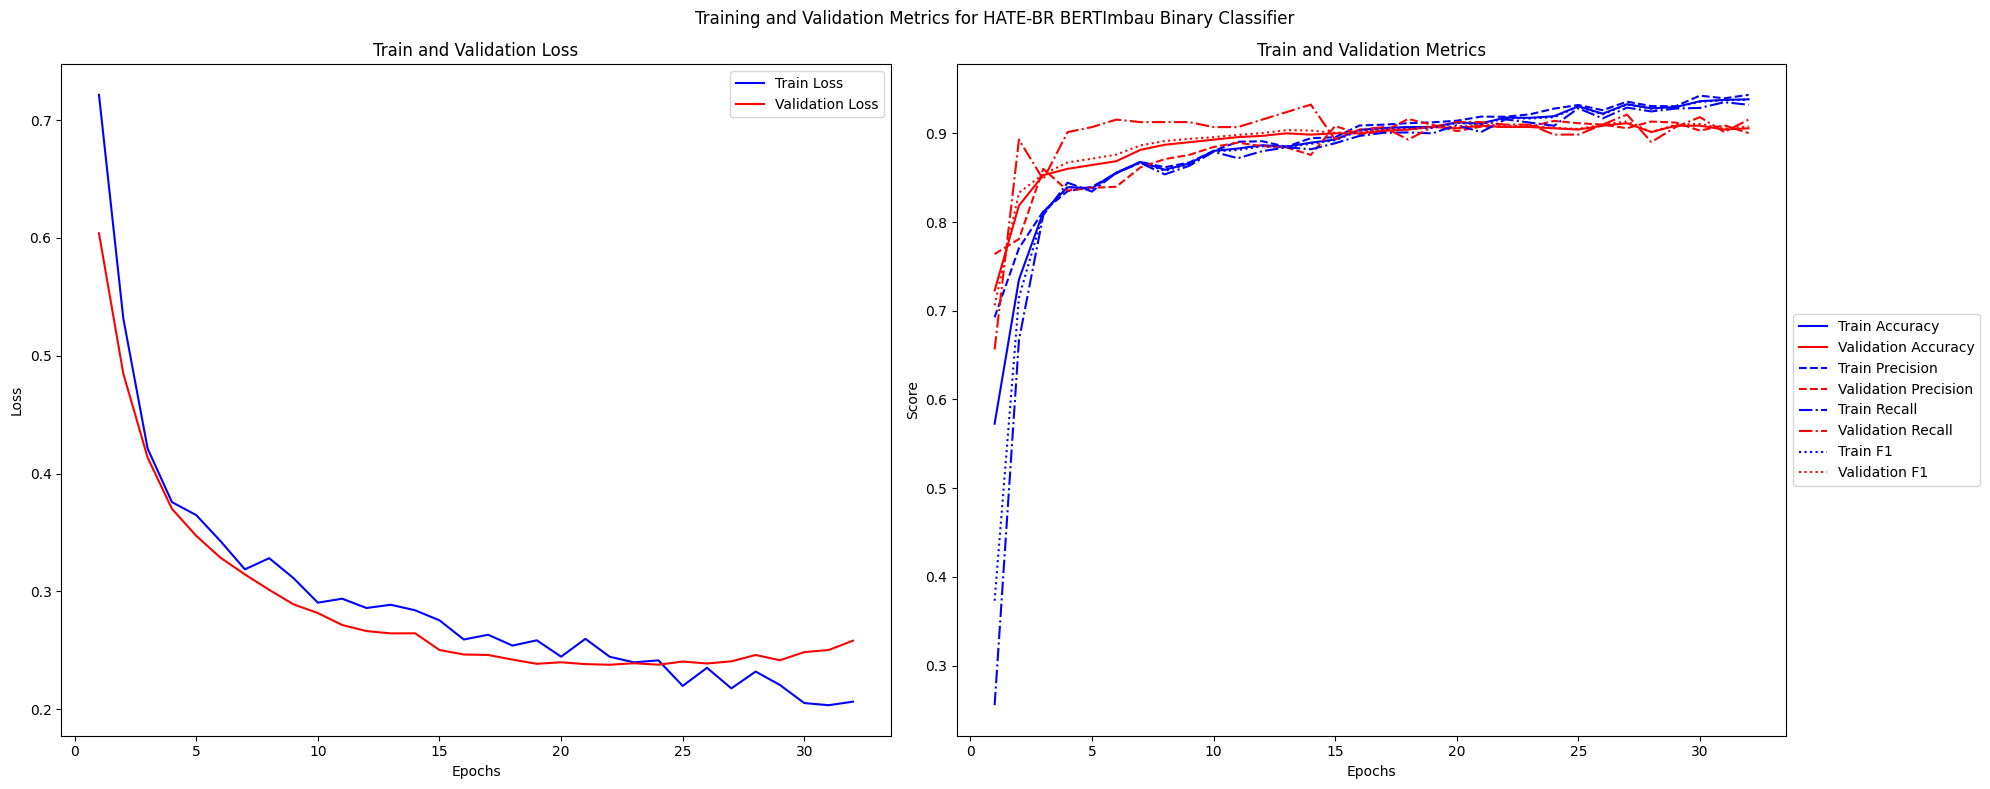

In [16]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
hatebr_binary_dataloader, HATEBR_BINARY_CLASSES, hatebr_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)
print(f"HATE-BR Train Dataset Size: {len(hatebr_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"HATE-BR Binary Model Class Names: {HATEBR_BINARY_CLASSES}")
hatebr_model = BERTMLCNNHateClassifier(num_classes=len(HATEBR_BINARY_CLASSES), model_name=BERT_MODELS["bert_timbau"], dropout_rate=0.5, freeze_bert_layers=0)

hatebr_binary_trainer = Trainer(
    model=hatebr_model,
    dataloader=hatebr_binary_dataloader,
    class_names=HATEBR_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_binary_bertcnn_hatebr_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(hatebr_binary_trainer.best_model_path, hatebr_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    hatebr_binary_trainer.load_model(best_model_path)
    hatebr_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_hatebr_binary_bertcnn_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    hatebr_binary_trainer.fit()
    hatebr_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_hatebr_binary_bertcnn_5e6.csv'))

history = hatebr_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

hatebr_binary_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTImbau Binary Classifier")

## HATE-BR BERTimbau Binary Classification

Loading dataset from https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv...
Loading multilabel dataset...
Loaded dataset with 7000 samples.
Dataset columns: ['comentario', 'label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Dataset shape: (7000, 8)
Multilabel columns: ['label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  hate
0                          velho nojento qual o mito   1.0
1               e a solidariedade com a nora do lula   0.0
2               prejudicando o meio ambiente de novo   0.0
3  essa menina foi usada aproveitaram a doença de...   1.0
4  lukinhadobreakoficia 

Test Epoch 1/50: 100%|██████████| 88/88 [00:34<00:00,  2.56batch/s, loss=0.342]


Test loss: 0.3365123825232414 accuracy: 0.8685714285714285 precision: 0.8793103448275862 recall: 0.8595505617977528 f1: 0.8693181818181818


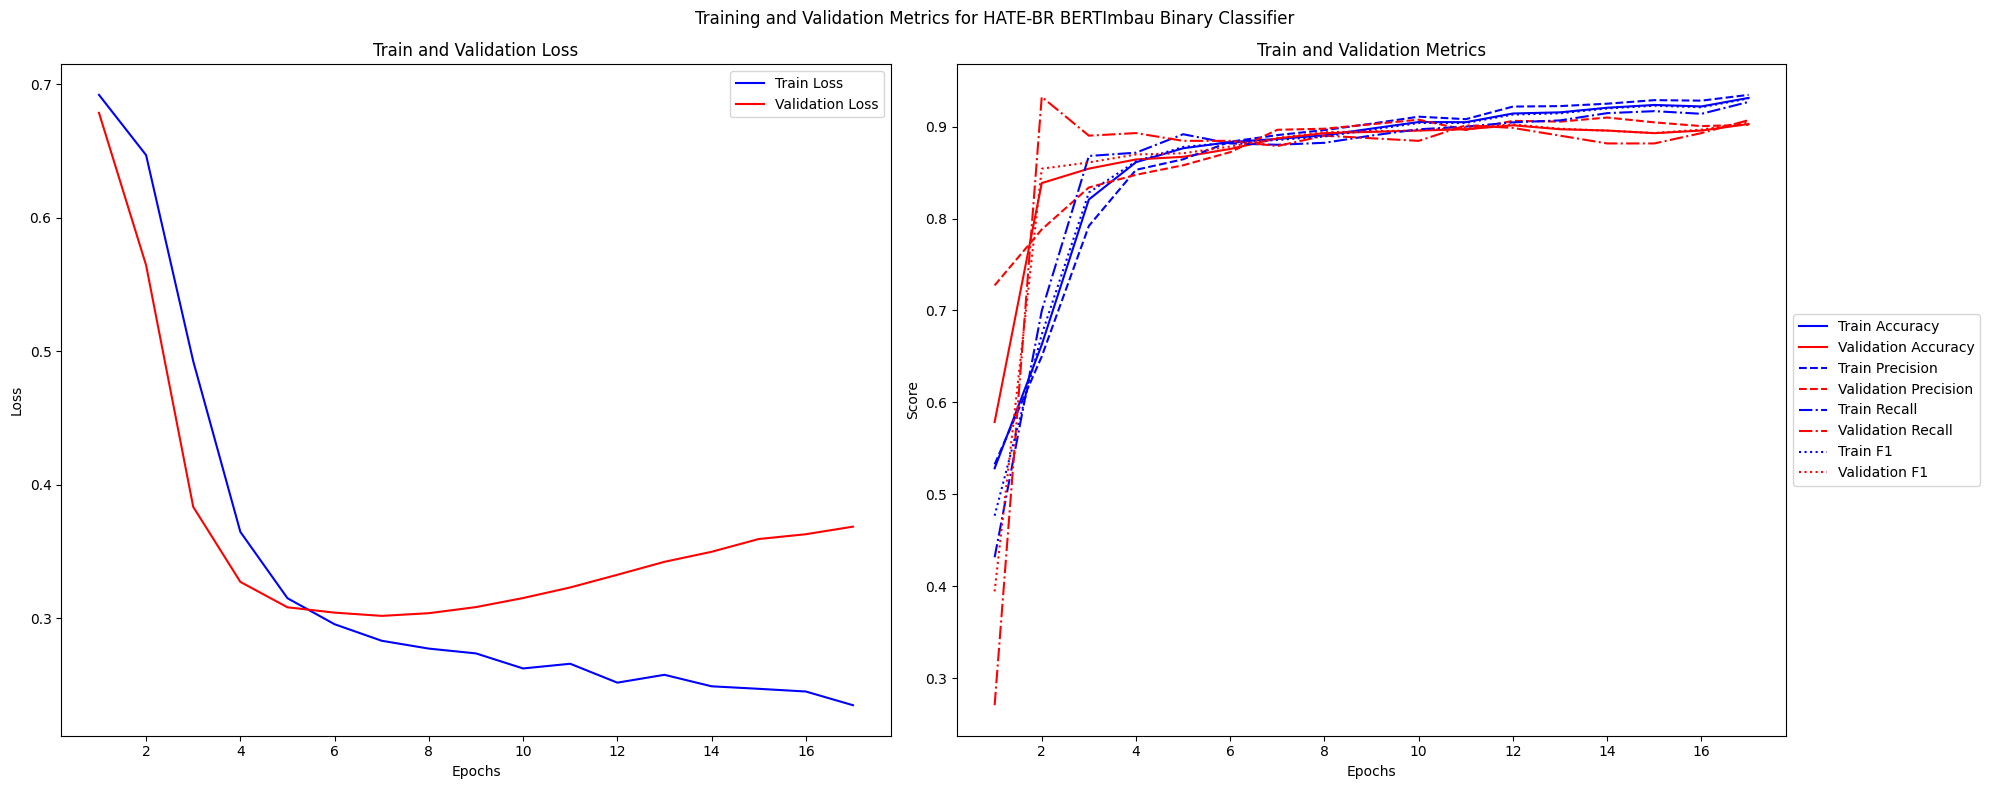

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
hatebr_binary_dataloader, HATEBR_BINARY_CLASSES, hatebr_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)
print(f"HATE-BR Train Dataset Size: {len(hatebr_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"HATE-BR Binary Model Class Names: {HATEBR_BINARY_CLASSES}")
hatebr_bert_model = BertClassifier(num_classes=len(HATEBR_BINARY_CLASSES), model_name=BERT_MODELS["bert_timbau"])

hatebr_bert_binary_trainer = Trainer(
    model=hatebr_bert_model,
    dataloader=hatebr_binary_dataloader,
    class_names=HATEBR_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_binary_bert_hatebr_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(hatebr_bert_binary_trainer.best_model_path, hatebr_bert_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    hatebr_bert_binary_trainer.load_model(best_model_path)
    hatebr_bert_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_hatebr_bert_binary_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    hatebr_bert_binary_trainer.fit()
    hatebr_bert_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_hatebr_bert_binary_5e6.csv'))

history = hatebr_bert_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

hatebr_bert_binary_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTImbau-CNN Binary Classifier")

## HATE-BR BERT-abaporu-CNN Binary Classification

Loading dataset from https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv...
Loading multilabel dataset...
Loaded dataset with 7000 samples.
Dataset columns: ['comentario', 'label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Dataset shape: (7000, 8)
Multilabel columns: ['label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  hate
0                          velho nojento qual o mito   1.0
1               e a solidariedade com a nora do lula   0.0
2               prejudicando o meio ambiente de novo   0.0
3  essa menina foi usada aproveitaram a doença de...   1.0
4  lukinhadobreakoficia 

Test Epoch 1/50: 100%|██████████| 88/88 [00:26<00:00,  3.29batch/s, loss=0.198]

Test loss: 0.19544798851182515 accuracy: 0.9285714285714286 precision: 0.9273743016759777 recall: 0.9325842696629213 f1: 0.9299719887955182


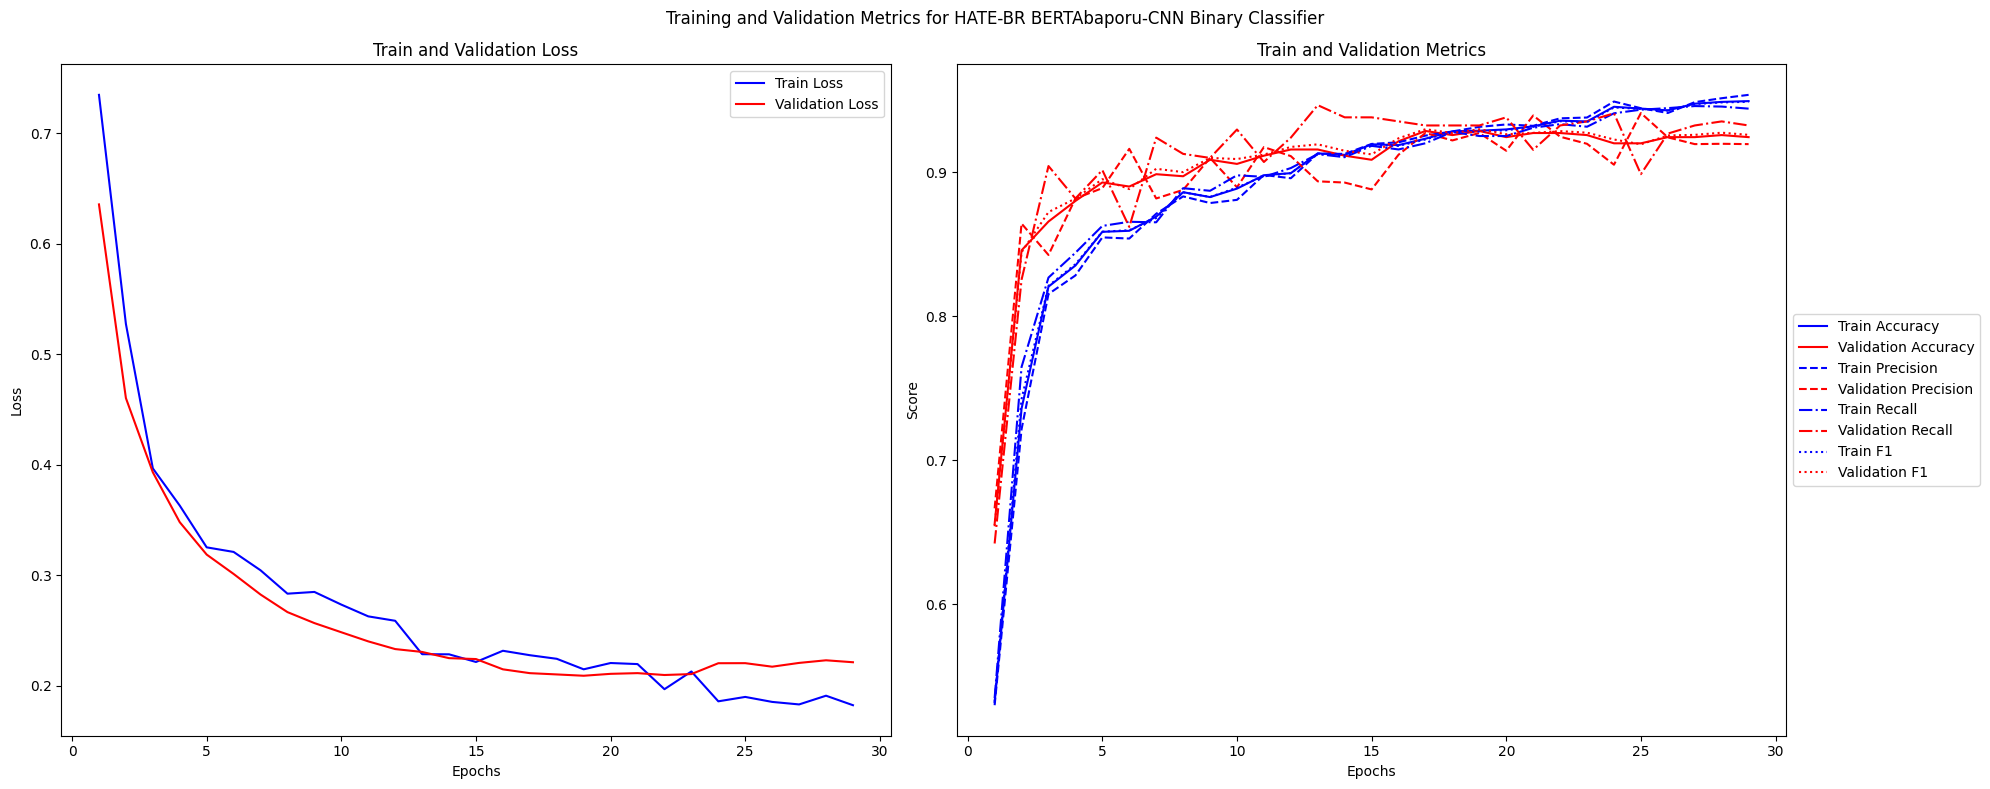

In [11]:
tokenizer = AutoTokenizer.from_pretrained(bert_abaporu_model)
hatebr_binary_dataloader, HATEBR_BINARY_CLASSES, hatebr_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)
print(f"HATE-BR Train Dataset Size: {len(hatebr_binary_dataloader['train'].dataset)}")

# Initialize the BERTAbaporu model for binary classification
print(f"HATE-BR Binary Model Class Names: {HATEBR_BINARY_CLASSES}")
hatebr_model = BERTMLCNNHateClassifier(num_classes=len(HATEBR_BINARY_CLASSES), model_name=BERT_MODELS["bert_abaporu"], dropout_rate=0.5, freeze_bert_layers=0)

hatebr_binary_abaporu_cnn_trainer = Trainer(
    model=hatebr_model,
    dataloader=hatebr_binary_dataloader,
    class_names=HATEBR_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertabaporu",
    best_model_filename="best_binary_bertcnn_hatebr_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(hatebr_binary_abaporu_cnn_trainer.best_model_path, hatebr_binary_abaporu_cnn_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    hatebr_binary_abaporu_cnn_trainer.load_model(best_model_path)
    hatebr_binary_abaporu_cnn_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_hatebr_binary_abaporu_cnn_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    hatebr_binary_abaporu_cnn_trainer.fit()
    hatebr_binary_abaporu_cnn_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_hatebr_binary_abaporu_cnn_5e6.csv'))

history = hatebr_binary_abaporu_cnn_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

hatebr_binary_abaporu_cnn_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTAbaporu-CNN Binary Classifier")

## HATE-BR BERT-abaporu Binary Classification

Loading dataset from https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv...
Loading multilabel dataset...
Loaded dataset with 7000 samples.
Dataset columns: ['comentario', 'label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Dataset shape: (7000, 8)
Multilabel columns: ['label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  hate
0                          velho nojento qual o mito   1.0
1               e a solidariedade com a nora do lula   0.0
2               prejudicando o meio ambiente de novo   0.0
3  essa menina foi usada aproveitaram a doença de...   1.0
4  lukinhadobreakoficia 

Test Epoch 1/50: 100%|██████████| 88/88 [00:26<00:00,  3.29batch/s, loss=0.473]

Test loss: 0.4722428177060051 accuracy: 0.7928571428571428 precision: 0.8206686930091185 recall: 0.7584269662921348 f1: 0.7883211678832117


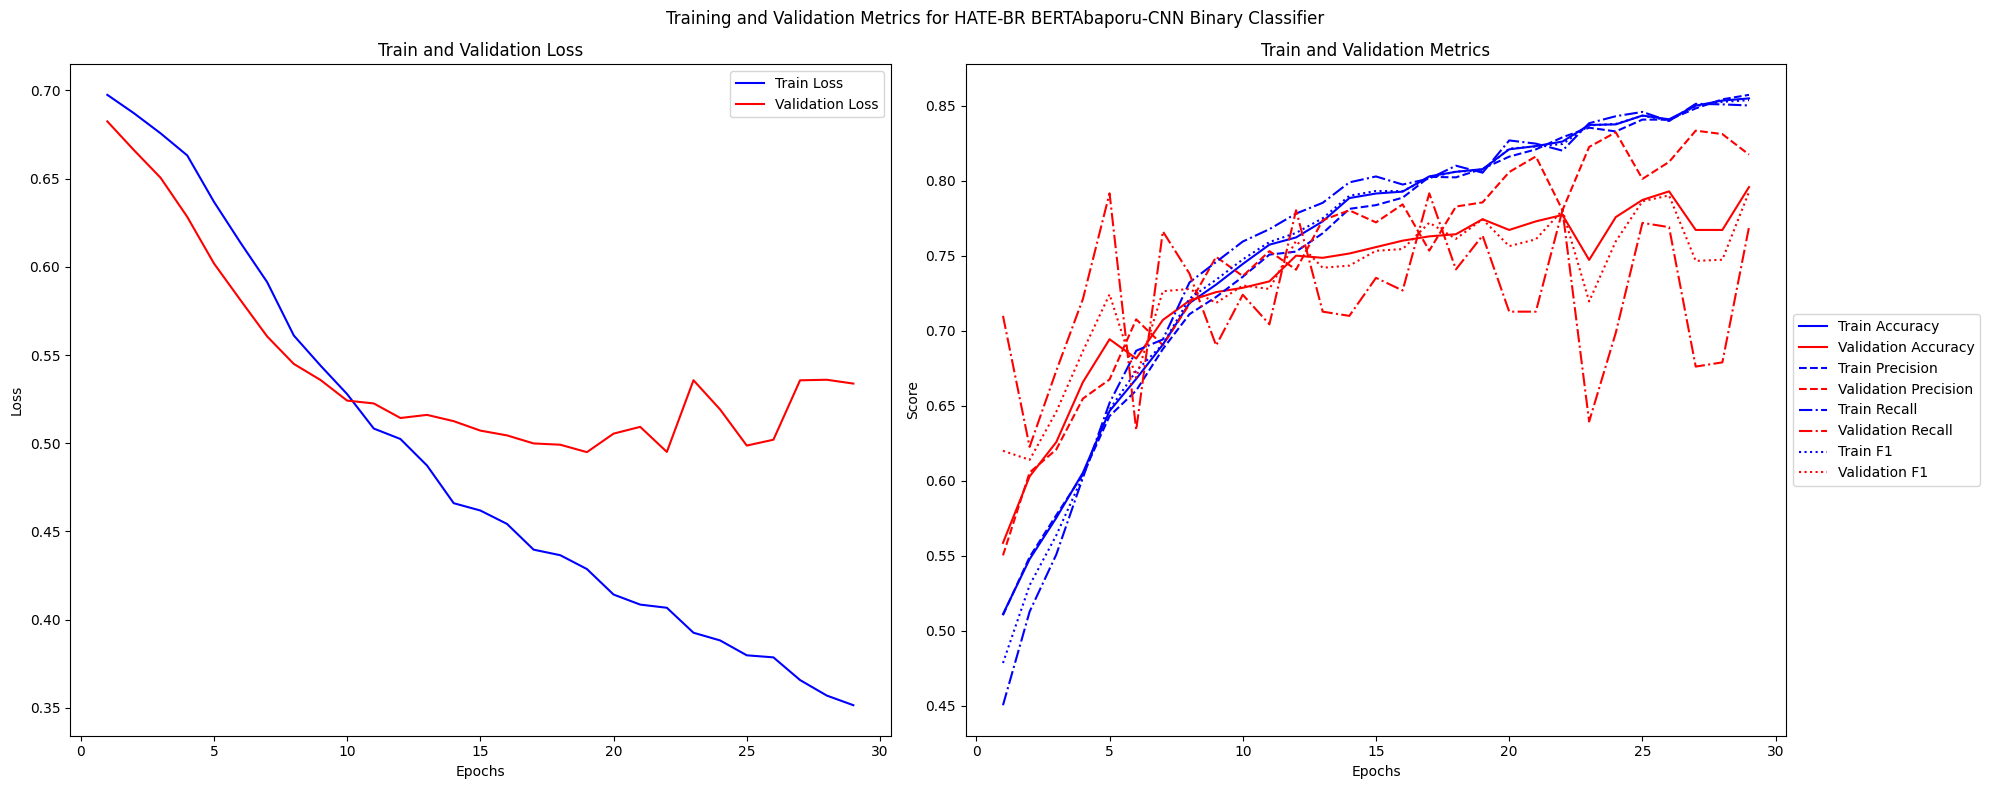

In [12]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
hatebr_binary_dataloader, HATEBR_BINARY_CLASSES, hatebr_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)
print(f"HATE-BR Train Dataset Size: {len(hatebr_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"HATE-BR Binary Model Class Names: {HATEBR_BINARY_CLASSES}")
hatebr_bert_abaporu_model = BertClassifier(num_classes=len(HATEBR_BINARY_CLASSES), model_name=BERT_MODELS["bert_abaporu"])

hatebr_bert_abaporu_binary_trainer = Trainer(
    model=hatebr_bert_abaporu_model,
    dataloader=hatebr_binary_dataloader,
    class_names=HATEBR_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertabaporu",
    best_model_filename="best_binary_bert_hatebr_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(hatebr_bert_abaporu_binary_trainer.best_model_path, hatebr_bert_abaporu_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    hatebr_bert_abaporu_binary_trainer.load_model(best_model_path)
    hatebr_bert_abaporu_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_hatebr_bert_abaporu_binary_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    hatebr_bert_abaporu_binary_trainer.fit()
    hatebr_bert_abaporu_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_hatebr_bert_abaporu_binary_5e6.csv'))

history = hatebr_bert_abaporu_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

hatebr_bert_abaporu_binary_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTAbaporu-CNN Binary Classifier")

## UlyssesSD-BR BERT-CNN Binary Classification

In [10]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
stance_binary_dataloader, STANCE_BINARY_CLASSES, stance_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=UlyssesSD_SPLITS)
print(f"Binary Train Dataset Size: {len(stance_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"Stance Binary Model Class Names: {STANCE_BINARY_CLASSES}")
binary_model = BERTMLCNNHateClassifier(num_classes=len(STANCE_BINARY_CLASSES), model_name=BERT_MODELS["bert_timbau"], dropout_rate=0.5, freeze_bert_layers=0)

ulysses_sd_bert_cnn_binary_trainer = Trainer(
    model=binary_model,
    dataloader=stance_binary_dataloader,
    class_names=STANCE_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=4e-5,
    epochs=50,
    patience=5,
    best_model_path="./bertimbau",
    best_model_filename="best_binary_bertcnn_stance_4e5_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(ulysses_sd_bert_cnn_binary_trainer.best_model_path, ulysses_sd_bert_cnn_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    ulysses_sd_bert_cnn_binary_trainer.load_model(best_model_path)
    ulysses_sd_bert_cnn_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_ulysses_sd_bert_cnn_binary_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    ulysses_sd_bert_cnn_binary_trainer.fit()
    ulysses_sd_bert_cnn_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_ulysses_sd_bert_cnn_binary_5e6.csv'))

history = ulysses_sd_bert_cnn_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

ulysses_sd_bert_cnn_binary_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTAbaporu-CNN Binary Classifier")

Loading dataset from https://github.com/Dyonnatan/UlyssesSD-Br/raw/refs/heads/main/data/UlyssesSD-Br.csv...
Loading multilabel dataset...
Loaded dataset with 50000 samples.
Dataset columns: ['Posicionamento', 'Conteúdo']
Dataset shape: (50000, 2)
Multilabel columns: ['Conteúdo']
Preprocessing datasets...
Maximum text length after preprocessing: 58
Dataset size after preprocessing: 50000 samples
Dataset size after removing NaN values: 50000 samples
Dataset size after removing empty texts: 50000 samples
Using UlyssesSD dataset...
Dataset columns: ['Posicionamento', 'Conteúdo']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  stance_label
0  O A distorcida análise desse falacioso déficit...             0
1  Todo país serio exige revalidação  Para exerce...             0
2  Quero meu direito de posse E cumpram o plebisc...             1
3        Essa reforma é injusta com os trabalhadores             0
4  Um total d

RuntimeError: Error(s) in loading state_dict for BERTMLCNNHateClassifier:
	Unexpected key(s) in state_dict: "classifier.1.weight", "classifier.1.bias", "classifier.1.running_mean", "classifier.1.running_var", "classifier.1.num_batches_tracked", "classifier.4.weight", "classifier.4.bias". 
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([48, 96]) from checkpoint, the shape in current model is torch.Size([1, 96]).
	size mismatch for classifier.0.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([1]).

## LLM Generated - Stance Detection

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
stance_multiclass_dataloader, STANCE_BINARY_CLASSES, stance_multiclass_dataset = load_dataset(tokenizer, max_length=40, batch_size=16, multi_label=False, num_workers=4, dataset=GENERATED_STANCE_CORPUS)
print(f"Multiclass Train Dataset Size: {len(stance_multiclass_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"Stance Binary Model Class Names: {GENERATED_STANCE_CORPUS_LABELS}")
bertcnn_multiclass_model = BERTMLCNNHateClassifier(num_classes=len(GENERATED_STANCE_CORPUS_LABELS), model_name=BERT_MODELS["bert_timbau"], dropout_rate=0.5, freeze_bert_layers=0)

llm_generated_sd_bert_cnn_multiclass_trainer = Trainer(
    model=bertcnn_multiclass_model,
    dataloader=stance_multiclass_dataloader,
    class_names=GENERATED_STANCE_CORPUS_LABELS,
    criterion=torch.nn.CrossEntropyLoss(reduction='mean'),
    learning_rate=4e-5,
    epochs=50,
    patience=5,
    best_model_path="./bertimbau",
    best_model_filename="best_multiclass_bertcnn_llmstance_4e3_model.pth",
    freeze_bert_layers=-1,
    multilabel=False,
)

# load the best model if it exists
best_model_path = os.path.join(llm_generated_sd_bert_cnn_multiclass_trainer.best_model_path, llm_generated_sd_bert_cnn_multiclass_trainer.best_model_filename)
# if os.path.exists(best_model_path):
#     print(f"Loading best model from {best_model_path}...")
#     llm_generated_sd_bert_cnn_multiclass_trainer.load_model(best_model_path)
#     llm_generated_sd_bert_cnn_multiclass_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_llm_generated_sd_bert_cnn_multiclass_4e3.csv'))
# else:
print(f"Best model not found at {best_model_path}. Training the model...")
llm_generated_sd_bert_cnn_multiclass_trainer.fit()
llm_generated_sd_bert_cnn_multiclass_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_llm_generated_sd_bert_cnn_multiclass_4e3.csv'))

history = llm_generated_sd_bert_cnn_multiclass_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

llm_generated_sd_bert_cnn_multiclass_trainer.plot_metrics(title="Training and Validation Metrics for LLM Generated BERTimbau-CNN Multiclass Stance Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

Loading dataset from ./data/stance.csv...
Loading multilabel dataset...
Loaded dataset with 3490 samples.
Dataset columns: ['text', 'category', 'stance', 'target']
Dataset shape: (3490, 4)
Multilabel columns: ['category', 'stance', 'target']
Preprocessing datasets...
Maximum text length after preprocessing: 21
Dataset size after preprocessing: 3490 samples
Dataset size after removing NaN values: 3490 samples
Dataset size after removing empty texts: 3490 samples
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  stance_label
0  Tem restaurante só com boliviano na cozinha Ch...             2
1  A família de sangue rejeitou mas os amigos vir...             2
2  Sou contra financiamento público de campanha d...             0
3     Antes de falar mal aprenda sobre a fé do outro             2
4  O texto usa palavra muito forte nem tudo é hom...             1
Class distribution:
stance_label    2433
dtype: int64
Loaded 2

Train Epoch 1/50: 100%|██████████| 153/153 [00:43<00:00,  3.48batch/s, loss=1.56]


Epoch 1 - Train Loss: 1.5508 - Train Accuracy: 0.3758 - Train F1: 0.2818 - Train Precision: 0.3651 - Train Recall: 0.3758


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=1.07]


Epoch 1 - Val Loss: 1.0782 - Val Accuracy: 0.4111 - Val F1: 0.3656 - Val Precision: 0.4349 - Val Recall: 0.4111
Validation loss improved from inf to 1.0782.
Best model saved to ./bertimbau/best_multiclass_bertcnn_llmstance_4e3_model.pth


Train Epoch 2/50: 100%|██████████| 153/153 [00:42<00:00,  3.60batch/s, loss=0.939]


Epoch 2 - Train Loss: 0.9383 - Train Accuracy: 0.5690 - Train F1: 0.5651 - Train Precision: 0.5661 - Train Recall: 0.5690


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=0.804]


Epoch 1 - Val Loss: 0.8029 - Val Accuracy: 0.6883 - Val F1: 0.6830 - Val Precision: 0.6925 - Val Recall: 0.6883
Validation loss improved from 1.0782 to 0.8029.
Best model saved to ./bertimbau/best_multiclass_bertcnn_llmstance_4e3_model.pth


Train Epoch 3/50: 100%|██████████| 153/153 [00:43<00:00,  3.55batch/s, loss=0.691]


Epoch 3 - Train Loss: 0.6912 - Train Accuracy: 0.7155 - Train F1: 0.7140 - Train Precision: 0.7163 - Train Recall: 0.7155


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.28batch/s, loss=0.742]


Epoch 1 - Val Loss: 0.7382 - Val Accuracy: 0.7208 - Val F1: 0.7165 - Val Precision: 0.7228 - Val Recall: 0.7208
Validation loss improved from 0.8029 to 0.7382.
Best model saved to ./bertimbau/best_multiclass_bertcnn_llmstance_4e3_model.pth


Train Epoch 4/50: 100%|██████████| 153/153 [00:42<00:00,  3.57batch/s, loss=0.569]


Epoch 4 - Train Loss: 0.5656 - Train Accuracy: 0.7736 - Train F1: 0.7725 - Train Precision: 0.7749 - Train Recall: 0.7736


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=0.704]


Epoch 1 - Val Loss: 0.7002 - Val Accuracy: 0.7228 - Val F1: 0.7193 - Val Precision: 0.7264 - Val Recall: 0.7228
Validation loss improved from 0.7382 to 0.7002.
Best model saved to ./bertimbau/best_multiclass_bertcnn_llmstance_4e3_model.pth


Train Epoch 5/50: 100%|██████████| 153/153 [00:43<00:00,  3.55batch/s, loss=0.476]


Epoch 5 - Train Loss: 0.4759 - Train Accuracy: 0.8101 - Train F1: 0.8094 - Train Precision: 0.8107 - Train Recall: 0.8101


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.28batch/s, loss=0.683]


Epoch 1 - Val Loss: 0.6781 - Val Accuracy: 0.7323 - Val F1: 0.7294 - Val Precision: 0.7325 - Val Recall: 0.7323
Validation loss improved from 0.7002 to 0.6781.
Best model saved to ./bertimbau/best_multiclass_bertcnn_llmstance_4e3_model.pth


Train Epoch 6/50:   0%|          | 0/153 [00:00<?, ?batch/s]

Loading dataset from ./data/stance.csv...
Loading multilabel dataset...
Loaded dataset with 3490 samples.
Dataset columns: ['text', 'category', 'stance', 'target']
Dataset shape: (3490, 4)
Multilabel columns: ['category', 'stance', 'target']
Preprocessing datasets...
Maximum text length after preprocessing: 21
Dataset size after preprocessing: 3490 samples
Dataset size after removing NaN values: 3490 samples
Dataset size after removing empty texts: 3490 samples
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  stance_label
0  Tem restaurante só com boliviano na cozinha Ch...             2
1  A família de sangue rejeitou mas os amigos vir...             2
2  Sou contra financiamento público de campanha d...             0
3     Antes de falar mal aprenda sobre a fé do outro             2
4  O texto usa palavra muito forte nem tudo é hom...             1
Class distribution:
stance_label    2433
dtype: int64
Loaded 2

Train Epoch 1/50: 100%|██████████| 153/153 [00:29<00:00,  5.21batch/s, loss=1.03]


Epoch 1 - Train Loss: 1.0255 - Train Accuracy: 0.4744 - Train F1: 0.4555 - Train Precision: 0.4765 - Train Recall: 0.4744


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.30batch/s, loss=0.935]


Epoch 1 - Val Loss: 0.9372 - Val Accuracy: 0.5755 - Val F1: 0.5644 - Val Precision: 0.5899 - Val Recall: 0.5755
Validation loss improved from inf to 0.9372.
Best model saved to ./bertimbau/best_multiclass_bert_llmstance_5e6_model.pth


Train Epoch 2/50: 100%|██████████| 153/153 [00:29<00:00,  5.24batch/s, loss=1.01]


Epoch 2 - Train Loss: 1.0143 - Train Accuracy: 0.5121 - Train F1: 0.5079 - Train Precision: 0.5102 - Train Recall: 0.5121


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.30batch/s, loss=0.871]


Epoch 1 - Val Loss: 0.8688 - Val Accuracy: 0.6004 - Val F1: 0.6004 - Val Precision: 0.6018 - Val Recall: 0.6004
Validation loss improved from 0.9372 to 0.8688.
Best model saved to ./bertimbau/best_multiclass_bert_llmstance_5e6_model.pth


Train Epoch 3/50: 100%|██████████| 153/153 [00:29<00:00,  5.25batch/s, loss=0.989]


Epoch 3 - Train Loss: 0.9879 - Train Accuracy: 0.5428 - Train F1: 0.5399 - Train Precision: 0.5411 - Train Recall: 0.5428


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=0.833]


Epoch 1 - Val Loss: 0.8318 - Val Accuracy: 0.6482 - Val F1: 0.6437 - Val Precision: 0.6577 - Val Recall: 0.6482
Validation loss improved from 0.8688 to 0.8318.
Best model saved to ./bertimbau/best_multiclass_bert_llmstance_5e6_model.pth


Train Epoch 4/50: 100%|██████████| 153/153 [00:29<00:00,  5.20batch/s, loss=0.964]


Epoch 4 - Train Loss: 0.9660 - Train Accuracy: 0.5469 - Train F1: 0.5446 - Train Precision: 0.5461 - Train Recall: 0.5469


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=0.857]


Epoch 1 - Val Loss: 0.8505 - Val Accuracy: 0.6252 - Val F1: 0.6260 - Val Precision: 0.6365 - Val Recall: 0.6252
Validation loss did not improve from 0.8318 to 0.8505.
Early stop counter: 1/5


Train Epoch 5/50: 100%|██████████| 153/153 [00:29<00:00,  5.24batch/s, loss=0.961]


Epoch 5 - Train Loss: 0.9585 - Train Accuracy: 0.5653 - Train F1: 0.5636 - Train Precision: 0.5637 - Train Recall: 0.5653


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=0.82] 


Epoch 1 - Val Loss: 0.8180 - Val Accuracy: 0.6577 - Val F1: 0.6532 - Val Precision: 0.6747 - Val Recall: 0.6577
Validation loss improved from 0.8318 to 0.8180.
Best model saved to ./bertimbau/best_multiclass_bert_llmstance_5e6_model.pth


Train Epoch 6/50: 100%|██████████| 153/153 [00:29<00:00,  5.14batch/s, loss=0.993]


Epoch 6 - Train Loss: 0.9926 - Train Accuracy: 0.5661 - Train F1: 0.5645 - Train Precision: 0.5653 - Train Recall: 0.5661


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=0.865]


Epoch 1 - Val Loss: 0.8712 - Val Accuracy: 0.5985 - Val F1: 0.5851 - Val Precision: 0.6366 - Val Recall: 0.5985
Validation loss did not improve from 0.8180 to 0.8712.
Early stop counter: 1/5


Train Epoch 7/50: 100%|██████████| 153/153 [00:29<00:00,  5.23batch/s, loss=0.961]


Epoch 7 - Train Loss: 0.9642 - Train Accuracy: 0.5661 - Train F1: 0.5652 - Train Precision: 0.5661 - Train Recall: 0.5661


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.28batch/s, loss=0.843]


Epoch 1 - Val Loss: 0.8427 - Val Accuracy: 0.6291 - Val F1: 0.6159 - Val Precision: 0.6699 - Val Recall: 0.6291
Validation loss did not improve from 0.8180 to 0.8427.
Early stop counter: 2/5


Train Epoch 8/50: 100%|██████████| 153/153 [00:29<00:00,  5.25batch/s, loss=0.972]


Epoch 8 - Train Loss: 0.9724 - Train Accuracy: 0.5591 - Train F1: 0.5576 - Train Precision: 0.5578 - Train Recall: 0.5591


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.27batch/s, loss=0.789]


Epoch 1 - Val Loss: 0.7891 - Val Accuracy: 0.6558 - Val F1: 0.6517 - Val Precision: 0.6630 - Val Recall: 0.6558
Validation loss improved from 0.8180 to 0.7891.
Best model saved to ./bertimbau/best_multiclass_bert_llmstance_5e6_model.pth


Train Epoch 9/50: 100%|██████████| 153/153 [00:29<00:00,  5.17batch/s, loss=0.965]


Epoch 9 - Train Loss: 0.9686 - Train Accuracy: 0.5645 - Train F1: 0.5629 - Train Precision: 0.5642 - Train Recall: 0.5645


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.30batch/s, loss=0.814]


Epoch 1 - Val Loss: 0.8116 - Val Accuracy: 0.6501 - Val F1: 0.6448 - Val Precision: 0.6761 - Val Recall: 0.6501
Validation loss did not improve from 0.7891 to 0.8116.
Early stop counter: 1/5


Train Epoch 10/50: 100%|██████████| 153/153 [00:36<00:00,  4.20batch/s, loss=0.94] 


Epoch 10 - Train Loss: 0.9451 - Train Accuracy: 0.5878 - Train F1: 0.5867 - Train Precision: 0.5869 - Train Recall: 0.5878


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=0.818]


Epoch 1 - Val Loss: 0.8181 - Val Accuracy: 0.6482 - Val F1: 0.6366 - Val Precision: 0.6774 - Val Recall: 0.6482
Validation loss did not improve from 0.7891 to 0.8181.
Early stop counter: 2/5


Train Epoch 11/50: 100%|██████████| 153/153 [00:29<00:00,  5.21batch/s, loss=0.971]


Epoch 11 - Train Loss: 0.9680 - Train Accuracy: 0.5739 - Train F1: 0.5722 - Train Precision: 0.5723 - Train Recall: 0.5739


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.30batch/s, loss=0.795]


Epoch 1 - Val Loss: 0.7944 - Val Accuracy: 0.6501 - Val F1: 0.6442 - Val Precision: 0.6639 - Val Recall: 0.6501
Validation loss did not improve from 0.7891 to 0.7944.
Early stop counter: 3/5


Train Epoch 12/50: 100%|██████████| 153/153 [00:29<00:00,  5.26batch/s, loss=0.958]


Epoch 12 - Train Loss: 0.9582 - Train Accuracy: 0.5767 - Train F1: 0.5756 - Train Precision: 0.5761 - Train Recall: 0.5767


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s, loss=0.787]


Epoch 1 - Val Loss: 0.7929 - Val Accuracy: 0.6692 - Val F1: 0.6670 - Val Precision: 0.6720 - Val Recall: 0.6692
Validation loss did not improve from 0.7891 to 0.7929.
Early stop counter: 4/5


Train Epoch 13/50: 100%|██████████| 153/153 [00:29<00:00,  5.12batch/s, loss=0.951]


Epoch 13 - Train Loss: 0.9502 - Train Accuracy: 0.5829 - Train F1: 0.5813 - Train Precision: 0.5818 - Train Recall: 0.5829


Val Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.28batch/s, loss=0.795]


Epoch 1 - Val Loss: 0.7912 - Val Accuracy: 0.6577 - Val F1: 0.6549 - Val Precision: 0.6633 - Val Recall: 0.6577
Validation loss did not improve from 0.7891 to 0.7912.
Early stop counter: 5/5
Early stopping triggered at epoch 13.
History saved to ./metrics/metrics_llm_generated_sd_bert_multiclass_5e6.csv


Test Epoch 1/50: 100%|██████████| 33/33 [00:25<00:00,  1.30batch/s, loss=0.781]


Test loss: 0.7774205821933169 accuracy: 0.6622137404580153 precision: 0.6670941216210895 recall: 0.6622137404580153 f1: 0.6605008707272748


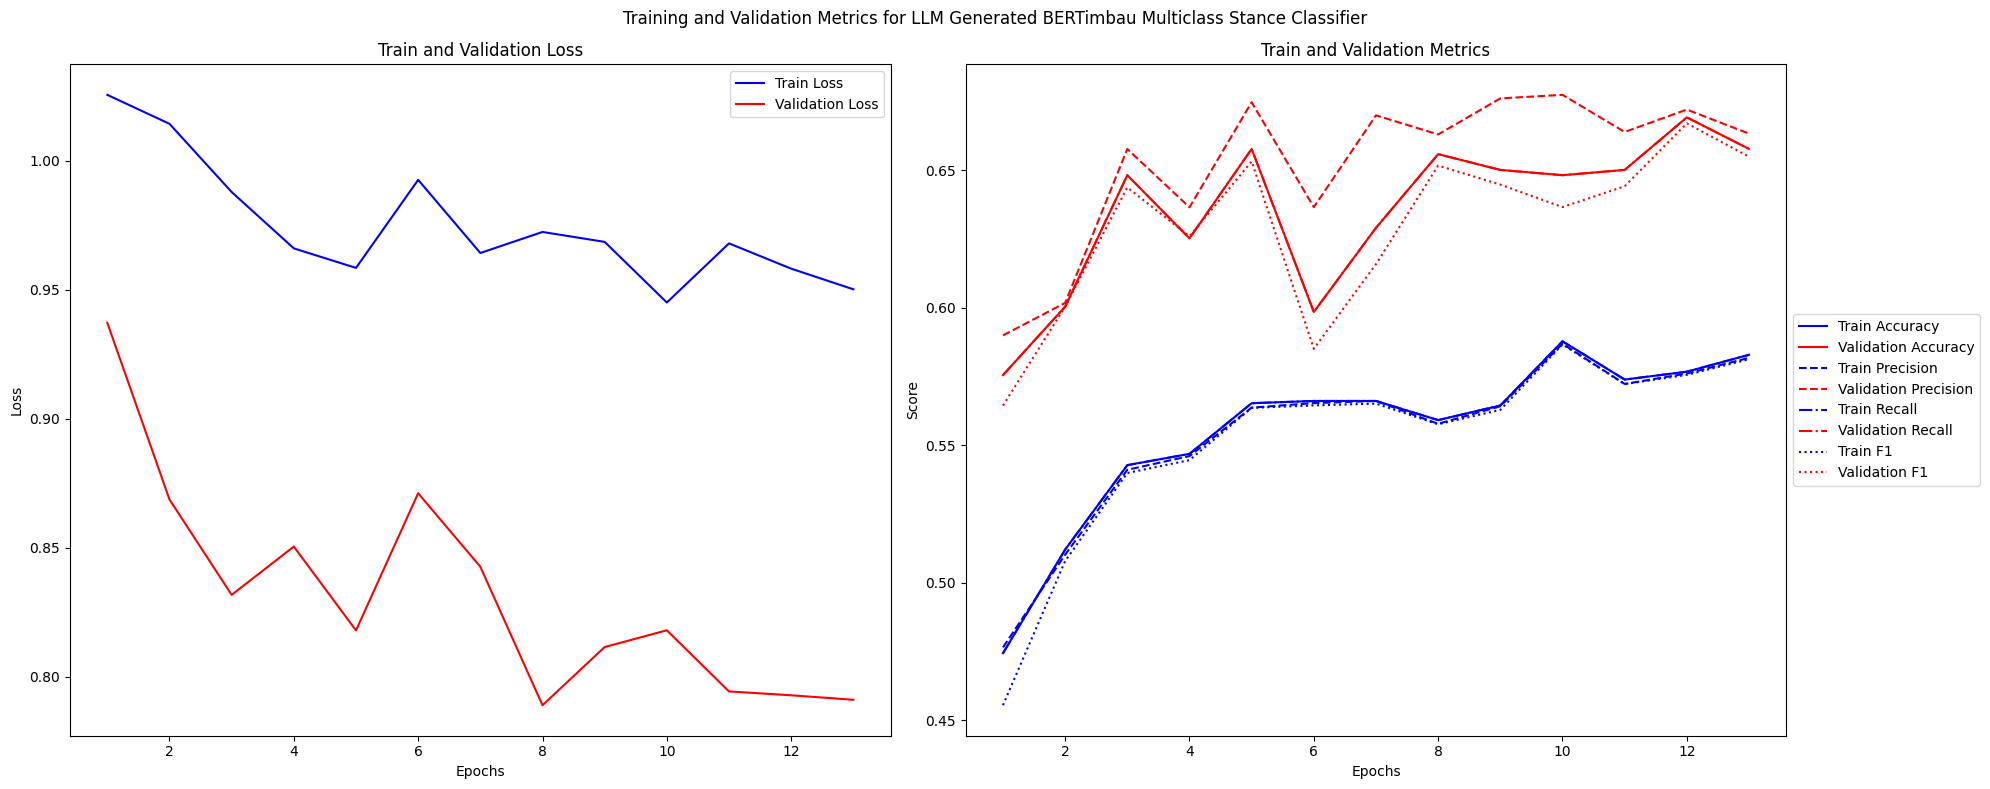

              precision    recall  f1-score     support
Contra         0.627049  0.746341  0.681514  205.000000
Neutro         0.692308  0.558140  0.618026  129.000000
A favor        0.693182  0.642105  0.666667  190.000000
accuracy       0.662214  0.662214  0.662214    0.662214
macro avg      0.670846  0.648862  0.655402  524.000000
weighted avg   0.667094  0.662214  0.660501  524.000000


In [8]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
stance_multiclass_dataloader, STANCE_BINARY_CLASSES, stance_multiclass_dataset = load_dataset(tokenizer, max_length=40, batch_size=16, multi_label=False, num_workers=4, dataset=GENERATED_STANCE_CORPUS)
print(f"Multiclass Train Dataset Size: {len(stance_multiclass_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"Stance Binary Model Class Names: {GENERATED_STANCE_CORPUS_LABELS}")
bert_multiclass_model = BertClassifier(num_classes=len(GENERATED_STANCE_CORPUS_LABELS), model_name=BERT_MODELS["bert_timbau"], freeze_bert_layers=True)

llm_generated_sd_bert_multiclass_trainer = Trainer(
    model=bert_multiclass_model,
    dataloader=stance_multiclass_dataloader,
    class_names=GENERATED_STANCE_CORPUS_LABELS,
    criterion=torch.nn.CrossEntropyLoss(),
    learning_rate=5e-3,
    epochs=50,
    patience=5,
    best_model_path="./bertimbau",
    best_model_filename="best_multiclass_bert_llmstance_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False,
)

# # load the best model if it exists
# best_model_path = os.path.join(llm_generated_sd_bert_multiclass_trainer.best_model_path, llm_generated_sd_bert_multiclass_trainer.best_model_filename)
# if os.path.exists(best_model_path):
#     print(f"Loading best model from {best_model_path}...")
#     llm_generated_sd_bert_multiclass_trainer.load_model(best_model_path)
#     llm_generated_sd_bert_multiclass_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_llm_generated_sd_bert_multiclass_5e6.csv'))
# else:
#     print(f"Best model not found at {best_model_path}. Training the model...")
llm_generated_sd_bert_multiclass_trainer.fit()
llm_generated_sd_bert_multiclass_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_llm_generated_sd_bert_multiclass_5e6.csv'))

history = llm_generated_sd_bert_multiclass_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

llm_generated_sd_bert_multiclass_trainer.plot_metrics(title="Training and Validation Metrics for LLM Generated BERTimbau Multiclass Stance Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

## Tupy-E Binary Training & Metrics

In [24]:
bertimbau_base_tokenizer = AutoTokenizer.from_pretrained(BERT_MODELS['tupye_binary_bert_base'])
tupye_binary_dataloader, TUPYE_BINARY_CLASSES, tupye_binary_dataset = load_dataset(bertimbau_base_tokenizer, max_length=80, batch_size=16, multi_label=False, num_workers=4, dataset=TUPYE_SPLITS)
print(f"Tupy-E Binary Train Dataset Size: {len(tupye_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"Tupy-E Binary Model Class Names: {TUPYE_BINARY_CLASSES}")

Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_train.csv...
Loading multilabel dataset...
Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_test.csv...
Loading multilabel dataset...
Loaded dataset with 34934 samples.
Dataset columns: ['text', 'aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Dataset shape: (34934, 17)
Multilabel columns: ['aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Preprocessing datasets...
Maximum text length after preprocessing: 220
Dataset size after preprocessing: 34928 samples
Dataset size after removing NaN values: 34928 samples
Dataset size after removing empty texts: 34928 samples


### Tupy-E BERTimbau Base - CNN Binary Classification

Freezing ALL BERT layers
Total parameters: 109,365,889
Trainable parameters: 442,753 (0.4%)
Using device: mps
Number of classes: 1
Using loss function: BCEWithLogitsLoss
Best model not found at ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth. Training the model...


Train Epoch 1/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.83batch/s, loss=0.23] 


Epoch 1 - Train Loss: 0.2297 - Train Accuracy: 0.9262 - Train F1: 0.6187 - Train Precision: 0.8178 - Train Recall: 0.4976


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.228]


Epoch 1 - Val Loss: 0.2283 - Val Accuracy: 0.9624 - Val F1: 0.8389 - Val Precision: 0.8750 - Val Recall: 0.8057
Validation loss improved from inf to 0.2283.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 2/50: 100%|██████████| 2183/2183 [02:41<00:00, 13.55batch/s, loss=0.144]


Epoch 2 - Train Loss: 0.1442 - Train Accuracy: 0.9531 - Train F1: 0.7944 - Train Precision: 0.8406 - Train Recall: 0.7530


Val Epoch 1/50: 100%|██████████| 273/273 [00:44<00:00,  6.09batch/s, loss=0.171]


Epoch 1 - Val Loss: 0.1707 - Val Accuracy: 0.9677 - Val F1: 0.8616 - Val Precision: 0.8978 - Val Recall: 0.8283
Validation loss improved from 0.2283 to 0.1707.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 3/50: 100%|██████████| 2183/2183 [02:49<00:00, 12.84batch/s, loss=0.135]


Epoch 3 - Train Loss: 0.1348 - Train Accuracy: 0.9557 - Train F1: 0.8056 - Train Precision: 0.8539 - Train Recall: 0.7625


Val Epoch 1/50: 100%|██████████| 273/273 [00:38<00:00,  7.02batch/s, loss=0.149]


Epoch 1 - Val Loss: 0.1490 - Val Accuracy: 0.9698 - Val F1: 0.8711 - Val Precision: 0.9028 - Val Recall: 0.8415
Validation loss improved from 0.1707 to 0.1490.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 4/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.83batch/s, loss=0.131]


Epoch 4 - Train Loss: 0.1310 - Train Accuracy: 0.9563 - Train F1: 0.8074 - Train Precision: 0.8595 - Train Recall: 0.7613


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.139]


Epoch 1 - Val Loss: 0.1388 - Val Accuracy: 0.9707 - Val F1: 0.8743 - Val Precision: 0.9119 - Val Recall: 0.8396
Validation loss improved from 0.1490 to 0.1388.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 5/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.84batch/s, loss=0.128]


Epoch 5 - Train Loss: 0.1281 - Train Accuracy: 0.9577 - Train F1: 0.8134 - Train Precision: 0.8657 - Train Recall: 0.7670


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.133]


Epoch 1 - Val Loss: 0.1325 - Val Accuracy: 0.9723 - Val F1: 0.8822 - Val Precision: 0.9115 - Val Recall: 0.8547
Validation loss improved from 0.1388 to 0.1325.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 6/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.128]


Epoch 6 - Train Loss: 0.1283 - Train Accuracy: 0.9579 - Train F1: 0.8154 - Train Precision: 0.8639 - Train Recall: 0.7720


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.133]


Epoch 1 - Val Loss: 0.1325 - Val Accuracy: 0.9727 - Val F1: 0.8857 - Val Precision: 0.9022 - Val Recall: 0.8698
Validation loss improved from 0.1325 to 0.1325.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 7/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.125]


Epoch 7 - Train Loss: 0.1254 - Train Accuracy: 0.9581 - Train F1: 0.8154 - Train Precision: 0.8677 - Train Recall: 0.7692


Val Epoch 1/50: 100%|██████████| 273/273 [00:42<00:00,  6.47batch/s, loss=0.131]


Epoch 1 - Val Loss: 0.1309 - Val Accuracy: 0.9730 - Val F1: 0.8870 - Val Precision: 0.9008 - Val Recall: 0.8736
Validation loss improved from 0.1325 to 0.1309.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 8/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.125]


Epoch 8 - Train Loss: 0.1252 - Train Accuracy: 0.9586 - Train F1: 0.8169 - Train Precision: 0.8730 - Train Recall: 0.7675


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.122]


Epoch 1 - Val Loss: 0.1216 - Val Accuracy: 0.9725 - Val F1: 0.8812 - Val Precision: 0.9271 - Val Recall: 0.8396
Validation loss improved from 0.1309 to 0.1216.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 9/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.122]


Epoch 9 - Train Loss: 0.1224 - Train Accuracy: 0.9597 - Train F1: 0.8217 - Train Precision: 0.8788 - Train Recall: 0.7715


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.126]


Epoch 1 - Val Loss: 0.1255 - Val Accuracy: 0.9730 - Val F1: 0.8848 - Val Precision: 0.9170 - Val Recall: 0.8547
Validation loss did not improve from 0.1216 to 0.1255.
Early stop counter: 1/10


Train Epoch 10/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.121]


Epoch 10 - Train Loss: 0.1214 - Train Accuracy: 0.9607 - Train F1: 0.8283 - Train Precision: 0.8744 - Train Recall: 0.7868


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.27batch/s, loss=0.126]


Epoch 1 - Val Loss: 0.1256 - Val Accuracy: 0.9739 - Val F1: 0.8906 - Val Precision: 0.9062 - Val Recall: 0.8755
Validation loss did not improve from 0.1216 to 0.1256.
Early stop counter: 2/10


Train Epoch 11/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.119]


Epoch 11 - Train Loss: 0.1193 - Train Accuracy: 0.9619 - Train F1: 0.8334 - Train Precision: 0.8793 - Train Recall: 0.7920


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.25batch/s, loss=0.128]


Epoch 1 - Val Loss: 0.1283 - Val Accuracy: 0.9734 - Val F1: 0.8897 - Val Precision: 0.8966 - Val Recall: 0.8830
Validation loss did not improve from 0.1216 to 0.1283.
Early stop counter: 3/10


Train Epoch 12/50: 100%|██████████| 2183/2183 [02:46<00:00, 13.11batch/s, loss=0.118]


Epoch 12 - Train Loss: 0.1176 - Train Accuracy: 0.9610 - Train F1: 0.8290 - Train Precision: 0.8764 - Train Recall: 0.7865


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.27batch/s, loss=0.117]


Epoch 1 - Val Loss: 0.1169 - Val Accuracy: 0.9723 - Val F1: 0.8810 - Val Precision: 0.9199 - Val Recall: 0.8453
Validation loss improved from 0.1216 to 0.1169.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 13/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.84batch/s, loss=0.118]


Epoch 13 - Train Loss: 0.1181 - Train Accuracy: 0.9620 - Train F1: 0.8333 - Train Precision: 0.8824 - Train Recall: 0.7894


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.25batch/s, loss=0.122]


Epoch 1 - Val Loss: 0.1214 - Val Accuracy: 0.9734 - Val F1: 0.8880 - Val Precision: 0.9091 - Val Recall: 0.8679
Validation loss did not improve from 0.1169 to 0.1214.
Early stop counter: 1/10


Train Epoch 14/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.85batch/s, loss=0.118]


Epoch 14 - Train Loss: 0.1176 - Train Accuracy: 0.9611 - Train F1: 0.8284 - Train Precision: 0.8831 - Train Recall: 0.7801


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.118]


Epoch 1 - Val Loss: 0.1177 - Val Accuracy: 0.9732 - Val F1: 0.8861 - Val Precision: 0.9155 - Val Recall: 0.8585
Validation loss did not improve from 0.1169 to 0.1177.
Early stop counter: 2/10


Train Epoch 15/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.85batch/s, loss=0.118]


Epoch 15 - Train Loss: 0.1177 - Train Accuracy: 0.9622 - Train F1: 0.8332 - Train Precision: 0.8880 - Train Recall: 0.7849


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.23batch/s, loss=0.121]


Epoch 1 - Val Loss: 0.1207 - Val Accuracy: 0.9739 - Val F1: 0.8910 - Val Precision: 0.9031 - Val Recall: 0.8792
Validation loss did not improve from 0.1169 to 0.1207.
Early stop counter: 3/10


Train Epoch 16/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.84batch/s, loss=0.117]


Epoch 16 - Train Loss: 0.1168 - Train Accuracy: 0.9624 - Train F1: 0.8349 - Train Precision: 0.8838 - Train Recall: 0.7911


Val Epoch 1/50: 100%|██████████| 273/273 [00:42<00:00,  6.47batch/s, loss=0.114]


Epoch 1 - Val Loss: 0.1143 - Val Accuracy: 0.9730 - Val F1: 0.8845 - Val Precision: 0.9187 - Val Recall: 0.8528
Validation loss improved from 0.1169 to 0.1143.
Best model saved to ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth


Train Epoch 17/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.84batch/s, loss=0.116]


Epoch 17 - Train Loss: 0.1157 - Train Accuracy: 0.9620 - Train F1: 0.8332 - Train Precision: 0.8820 - Train Recall: 0.7896


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.119]


Epoch 1 - Val Loss: 0.1193 - Val Accuracy: 0.9734 - Val F1: 0.8893 - Val Precision: 0.8996 - Val Recall: 0.8792
Validation loss did not improve from 0.1143 to 0.1193.
Early stop counter: 1/10


Train Epoch 18/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.85batch/s, loss=0.116]


Epoch 18 - Train Loss: 0.1159 - Train Accuracy: 0.9628 - Train F1: 0.8372 - Train Precision: 0.8843 - Train Recall: 0.7949


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.22batch/s, loss=0.119]


Epoch 1 - Val Loss: 0.1189 - Val Accuracy: 0.9732 - Val F1: 0.8867 - Val Precision: 0.9105 - Val Recall: 0.8642
Validation loss did not improve from 0.1143 to 0.1189.
Early stop counter: 2/10


Train Epoch 19/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.117]


Epoch 19 - Train Loss: 0.1169 - Train Accuracy: 0.9623 - Train F1: 0.8345 - Train Precision: 0.8842 - Train Recall: 0.7901


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.21batch/s, loss=0.124]


Epoch 1 - Val Loss: 0.1238 - Val Accuracy: 0.9730 - Val F1: 0.8880 - Val Precision: 0.8931 - Val Recall: 0.8830
Validation loss did not improve from 0.1143 to 0.1238.
Early stop counter: 3/10


Train Epoch 20/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.87batch/s, loss=0.114] 


Epoch 20 - Train Loss: 0.1136 - Train Accuracy: 0.9633 - Train F1: 0.8392 - Train Precision: 0.8871 - Train Recall: 0.7963


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.19batch/s, loss=0.115]


Epoch 1 - Val Loss: 0.1153 - Val Accuracy: 0.9732 - Val F1: 0.8865 - Val Precision: 0.9122 - Val Recall: 0.8623
Validation loss did not improve from 0.1143 to 0.1153.
Early stop counter: 4/10


Train Epoch 21/50: 100%|██████████| 2183/2183 [02:44<00:00, 13.31batch/s, loss=0.114] 


Epoch 21 - Train Loss: 0.1141 - Train Accuracy: 0.9636 - Train F1: 0.8402 - Train Precision: 0.8907 - Train Recall: 0.7951


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.119]


Epoch 1 - Val Loss: 0.1189 - Val Accuracy: 0.9741 - Val F1: 0.8915 - Val Precision: 0.9080 - Val Recall: 0.8755
Validation loss did not improve from 0.1143 to 0.1189.
Early stop counter: 5/10


Train Epoch 22/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.112]


Epoch 22 - Train Loss: 0.1118 - Train Accuracy: 0.9640 - Train F1: 0.8425 - Train Precision: 0.8890 - Train Recall: 0.8006


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.26batch/s, loss=0.119]


Epoch 1 - Val Loss: 0.1187 - Val Accuracy: 0.9741 - Val F1: 0.8915 - Val Precision: 0.9080 - Val Recall: 0.8755
Validation loss did not improve from 0.1143 to 0.1187.
Early stop counter: 6/10


Train Epoch 23/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.86batch/s, loss=0.115]


Epoch 23 - Train Loss: 0.1152 - Train Accuracy: 0.9625 - Train F1: 0.8367 - Train Precision: 0.8783 - Train Recall: 0.7989


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.21batch/s, loss=0.115]


Epoch 1 - Val Loss: 0.1146 - Val Accuracy: 0.9730 - Val F1: 0.8848 - Val Precision: 0.9170 - Val Recall: 0.8547
Validation loss did not improve from 0.1143 to 0.1146.
Early stop counter: 7/10


Train Epoch 24/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.85batch/s, loss=0.111]


Epoch 24 - Train Loss: 0.1105 - Train Accuracy: 0.9641 - Train F1: 0.8427 - Train Precision: 0.8910 - Train Recall: 0.7994


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.25batch/s, loss=0.116]


Epoch 1 - Val Loss: 0.1159 - Val Accuracy: 0.9734 - Val F1: 0.8876 - Val Precision: 0.9124 - Val Recall: 0.8642
Validation loss did not improve from 0.1143 to 0.1159.
Early stop counter: 8/10


Train Epoch 25/50: 100%|██████████| 2183/2183 [02:37<00:00, 13.88batch/s, loss=0.113]


Epoch 25 - Train Loss: 0.1133 - Train Accuracy: 0.9634 - Train F1: 0.8400 - Train Precision: 0.8845 - Train Recall: 0.7999


Val Epoch 1/50: 100%|██████████| 273/273 [00:43<00:00,  6.35batch/s, loss=0.119]


Epoch 1 - Val Loss: 0.1184 - Val Accuracy: 0.9741 - Val F1: 0.8927 - Val Precision: 0.8987 - Val Recall: 0.8868
Validation loss did not improve from 0.1143 to 0.1184.
Early stop counter: 9/10


Train Epoch 26/50: 100%|██████████| 2183/2183 [02:36<00:00, 13.92batch/s, loss=0.111]


Epoch 26 - Train Loss: 0.1112 - Train Accuracy: 0.9640 - Train F1: 0.8427 - Train Precision: 0.8888 - Train Recall: 0.8010


Val Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.21batch/s, loss=0.115]


Epoch 1 - Val Loss: 0.1151 - Val Accuracy: 0.9743 - Val F1: 0.8923 - Val Precision: 0.9098 - Val Recall: 0.8755
Validation loss did not improve from 0.1143 to 0.1151.
Early stop counter: 10/10
Early stopping triggered at epoch 26.
History saved to ./metrics/metrics_tupye_bertimbau_cnn_binary_5e6.csv


Test Epoch 1/50: 100%|██████████| 273/273 [00:37<00:00,  7.25batch/s, loss=0.125]


Test loss: 0.12442890527375015 accuracy: 0.9695373339441136 precision: 0.8786692759295499 recall: 0.8634615384615385 f1: 0.8709990300678953


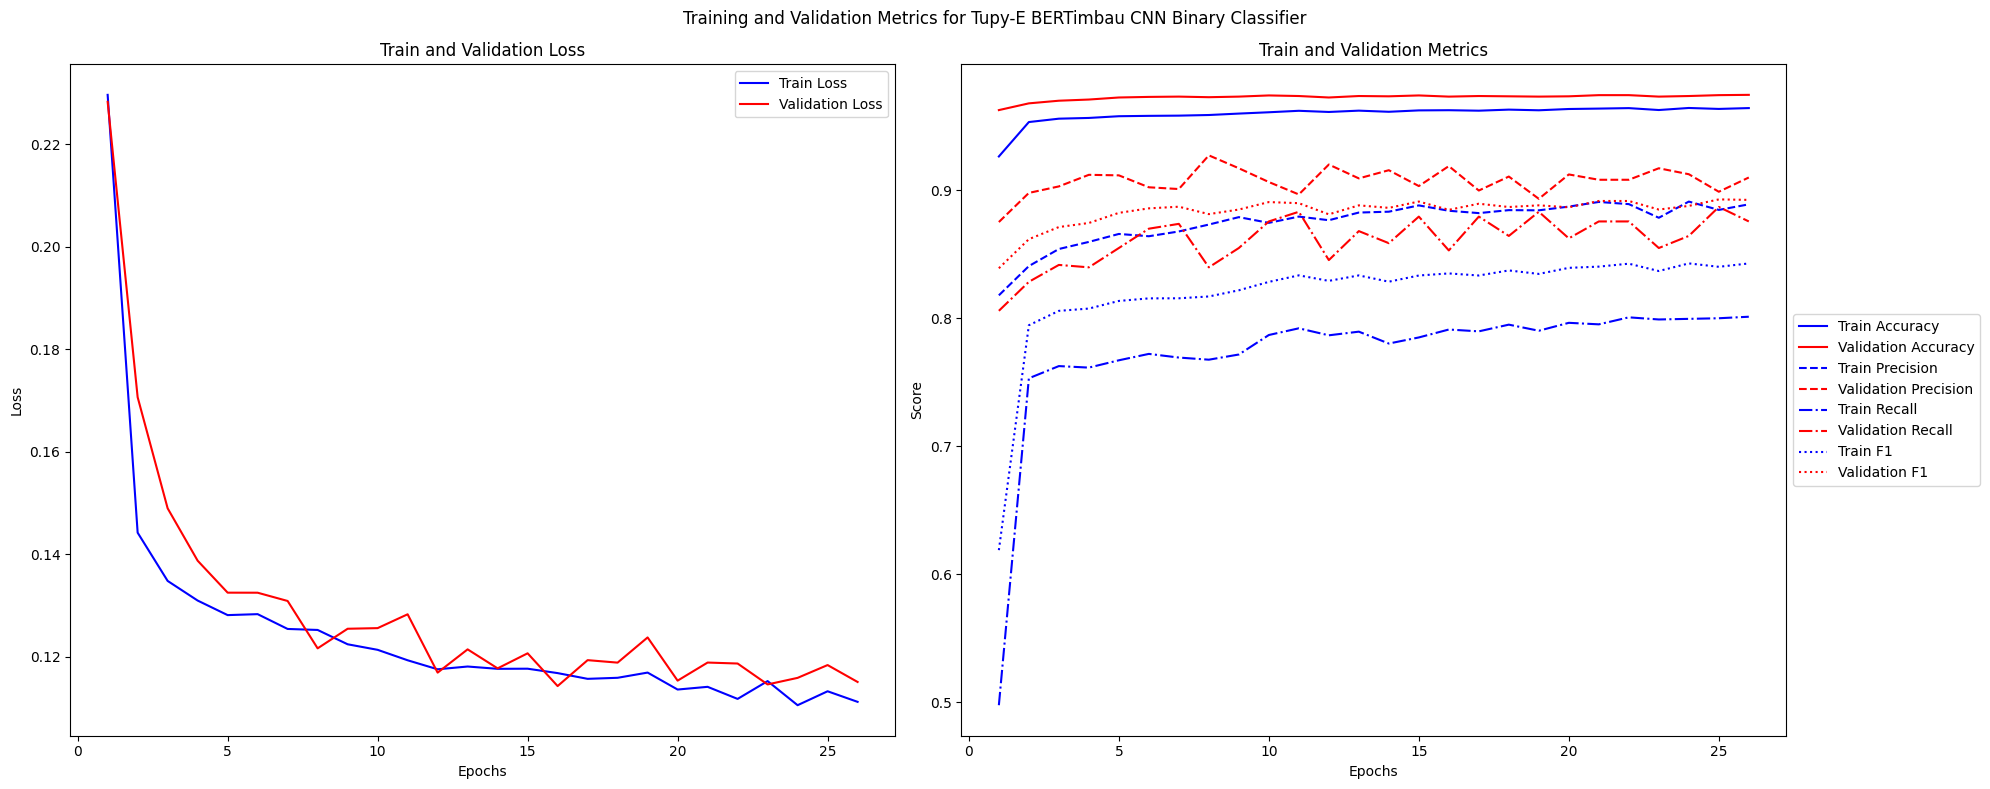

In [25]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_bertimbau_cnn_base_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_BINARY_CLASSES), model_name=BERT_MODELS['tupye_binary_bert_base'], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_bertimbau_cnn_binary_trainer = Trainer(
    model=tupye_bertimbau_cnn_base_model,
    dataloader=tupye_binary_dataloader,
    class_names=TUPYE_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_binary_bertcnn_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(tupye_bertimbau_cnn_binary_trainer.best_model_path, tupye_bertimbau_cnn_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_bertimbau_cnn_binary_trainer.load_model(best_model_path)
    tupye_bertimbau_cnn_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_binary_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_bertimbau_cnn_binary_trainer.fit()
    tupye_bertimbau_cnn_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_binary_5e6.csv'))

history = tupye_bertimbau_cnn_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_bertimbau_cnn_binary_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau CNN Binary Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

## Tupy-E Multilabel Training & Metrics

In [ ]:
bertimbau_tokenizer = AutoTokenizer.from_pretrained(BERT_MODELS["tupye_multilabel_bert_base"])
tupye_cnn_multilabel_dataloader, TUPYE_MULTILABEL_CLASSES, tupye_multilabel_dataset = load_dataset(bertimbau_tokenizer, max_length=60, batch_size=8, multi_label=True, num_workers=4, dataset=TUPYE_SPLITS)
print(f"Tupy-E Multilabel Train Dataset Size: {len(tupye_cnn_multilabel_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"Tupy-E Multilabel Model Class Names: {TUPYE_MULTILABEL_CLASSES}")

### Tupy-E BERTimbau Base - CNN Multilabel Classification

Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_train.csv...
Loading multilabel dataset...
Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_test.csv...
Loading multilabel dataset...
Loaded dataset with 34934 samples.
Dataset columns: ['text', 'aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Dataset shape: (34934, 17)
Multilabel columns: ['aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Preprocessing datasets...
Maximum text length after preprocessing: 220
Dataset size after preprocessing: 34851 samples
Dataset size after removing NaN values: 34851 samples
Dataset size after removing empty texts: 34851 samples


Test Epoch 1/50: 100%|██████████| 545/545 [00:36<00:00, 15.04batch/s, loss=0.0729]


Test loss: 0.07273764631309367 accuracy: 0.8198715006883892 precision: 0.8942175309775127 recall: 0.8902784151751567 f1: 0.8844424047728316


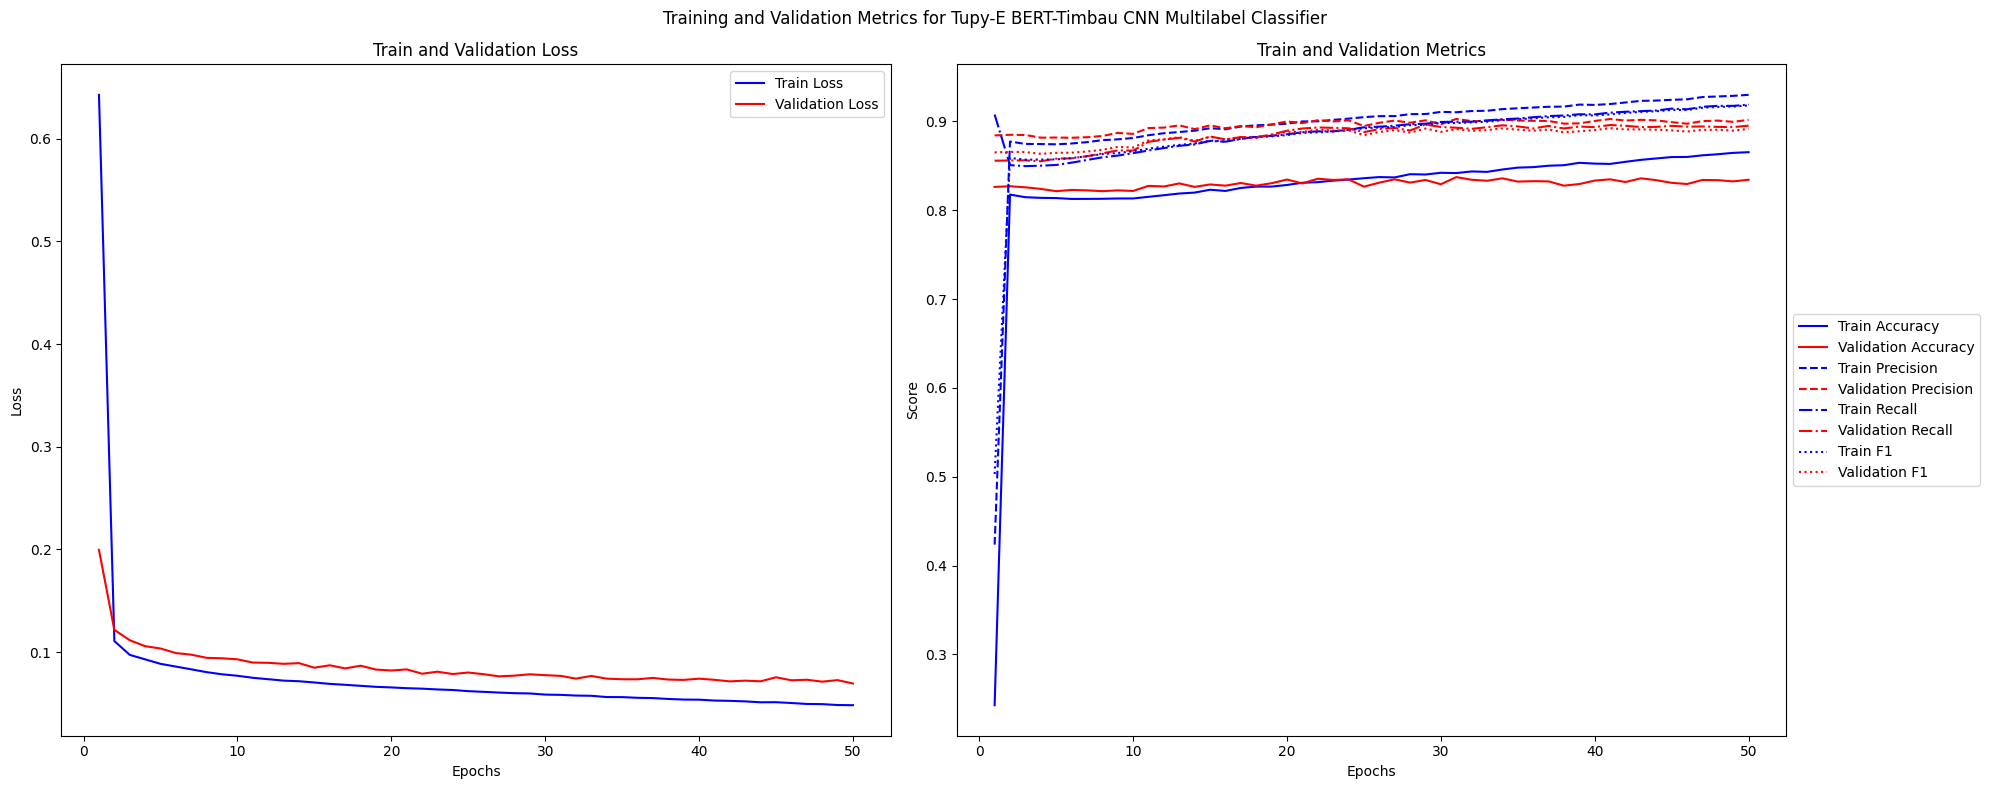

                       precision    recall  f1-score  support
ageism                  0.000000  0.000000  0.000000      6.0
aporophobia             0.000000  0.000000  0.000000      9.0
body_shame              0.629630  0.607143  0.618182     28.0
capacitism              0.000000  0.000000  0.000000      4.0
lgbtphobia              0.746479  0.688312  0.716216     77.0
political               0.547368  0.444444  0.490566    117.0
racism                  0.500000  0.321429  0.391304     28.0
religious_intolerance   0.500000  0.125000  0.200000      8.0
misogyny                0.713178  0.519774  0.601307    177.0
xenophobia              0.666667  0.318182  0.430769     44.0
other                   0.524590  0.498886  0.511416    449.0
not_hate                0.941710  0.952818  0.947231   3815.0
micro avg               0.881075  0.860353  0.870591   4762.0
macro avg               0.480802  0.372999  0.408916   4762.0
weighted avg            0.869568  0.860353  0.863316   4762.0
samples 

In [ ]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_bertcnn_timbau_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_MULTILABEL_CLASSES), model_name=BERT_MODELS["tupye_multilabel_bert_base"], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_bertimbau_cnn_multilabel_trainer = Trainer(
    model=tupye_bertcnn_timbau_model,
    dataloader=tupye_cnn_multilabel_dataloader,
    class_names=TUPYE_MULTILABEL_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_multilabel_bertcnn_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=True
)

# load the best model if it exists
best_model_path = os.path.join(tupye_bertimbau_cnn_multilabel_trainer.best_model_path, tupye_bertimbau_cnn_multilabel_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_bertimbau_cnn_multilabel_trainer.load_model(best_model_path)
    tupye_bertimbau_cnn_multilabel_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_multilabel_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_bertimbau_cnn_multilabel_trainer.fit()
    tupye_bertimbau_cnn_multilabel_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_multilabel_5e6.csv'))

history = tupye_bertimbau_cnn_multilabel_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_bertimbau_cnn_multilabel_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau CNN Multilabel Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

### Tupy-E BERTimbau Large - CNN Multilabel Classification

In [8]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_large_bertcnn_timbau_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_MULTILABEL_CLASSES), model_name=BERT_MODELS["tupye_multilabel_bert_large"], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_large_bertimbau_cnn_multilabel_trainer = Trainer(
    model=tupye_large_bertcnn_timbau_model,
    dataloader=tupye_cnn_multilabel_dataloader,
    class_names=TUPYE_MULTILABEL_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=3,
    best_model_path="./bertimbau",
    best_model_filename="best_multilabel_bertcnn_large_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=True
)

# load the best model if it exists
best_model_path = os.path.join(tupye_large_bertimbau_cnn_multilabel_trainer.best_model_path, tupye_large_bertimbau_cnn_multilabel_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_large_bertimbau_cnn_multilabel_trainer.load_model(best_model_path)
    tupye_large_bertimbau_cnn_multilabel_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_large_bertimbau_cnn_multilabel_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_large_bertimbau_cnn_multilabel_trainer.fit()
    tupye_large_bertimbau_cnn_multilabel_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_large_bertimbau_cnn_multilabel_5e6.csv'))

history = tupye_large_bertimbau_cnn_multilabel_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_large_bertimbau_cnn_multilabel_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau Large CNN Multilabel Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_train.csv...
Loading multilabel dataset...
Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_test.csv...
Loading multilabel dataset...
Loaded dataset with 34934 samples.
Dataset columns: ['text', 'aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Dataset shape: (34934, 17)
Multilabel columns: ['aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Preprocessing datasets...
Maximum text length after preprocessing: 220
Dataset size after preprocessing: 34851 samples
Dataset size after removing NaN values: 34851 samples
Dataset size after removing empty texts: 34851 samples


Train Epoch 1/50: 100%|██████████| 4357/4357 [06:24<00:00, 11.34batch/s, loss=0.505]


Epoch 1 - Train Loss: 0.5041 - Train Accuracy: 0.1502 - Train F1: 0.5024 - Train Precision: 0.3945 - Train Recall: 0.9029


Val Epoch 1/50: 100%|██████████| 545/545 [01:03<00:00,  8.56batch/s, loss=0.266]


Epoch 1 - Val Loss: 0.2664 - Val Accuracy: 0.8015 - Val F1: 0.8840 - Val Precision: 0.8747 - Val Recall: 0.9175
Validation loss improved from inf to 0.2664.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 2/50: 100%|██████████| 4357/4357 [06:37<00:00, 10.96batch/s, loss=0.0989]


Epoch 2 - Train Loss: 0.0988 - Train Accuracy: 0.8209 - Train F1: 0.8837 - Train Precision: 0.8901 - Train Recall: 0.8928


Val Epoch 1/50: 100%|██████████| 545/545 [01:06<00:00,  8.25batch/s, loss=0.122]


Epoch 1 - Val Loss: 0.1217 - Val Accuracy: 0.8625 - Val F1: 0.9166 - Val Precision: 0.9264 - Val Recall: 0.9195
Validation loss improved from 0.2664 to 0.1217.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 3/50: 100%|██████████| 4357/4357 [06:36<00:00, 10.99batch/s, loss=0.0631]


Epoch 3 - Train Loss: 0.0630 - Train Accuracy: 0.8537 - Train F1: 0.9018 - Train Precision: 0.9129 - Train Recall: 0.9023


Val Epoch 1/50: 100%|██████████| 545/545 [01:05<00:00,  8.26batch/s, loss=0.0972]


Epoch 1 - Val Loss: 0.0971 - Val Accuracy: 0.8712 - Val F1: 0.9220 - Val Precision: 0.9329 - Val Recall: 0.9232
Validation loss improved from 0.1217 to 0.0971.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 4/50: 100%|██████████| 4357/4357 [06:36<00:00, 10.99batch/s, loss=0.0556]


Epoch 4 - Train Loss: 0.0555 - Train Accuracy: 0.8586 - Train F1: 0.9082 - Train Precision: 0.9190 - Train Recall: 0.9095


Val Epoch 1/50: 100%|██████████| 545/545 [01:06<00:00,  8.24batch/s, loss=0.0864]


Epoch 1 - Val Loss: 0.0864 - Val Accuracy: 0.8728 - Val F1: 0.9247 - Val Precision: 0.9389 - Val Recall: 0.9231
Validation loss improved from 0.0971 to 0.0864.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 5/50: 100%|██████████| 4357/4357 [06:40<00:00, 10.88batch/s, loss=0.0522]


Epoch 5 - Train Loss: 0.0522 - Train Accuracy: 0.8632 - Train F1: 0.9127 - Train Precision: 0.9228 - Train Recall: 0.9145


Val Epoch 1/50: 100%|██████████| 545/545 [01:08<00:00,  7.97batch/s, loss=0.0796]


Epoch 1 - Val Loss: 0.0795 - Val Accuracy: 0.8793 - Val F1: 0.9306 - Val Precision: 0.9406 - Val Recall: 0.9327
Validation loss improved from 0.0864 to 0.0795.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 6/50: 100%|██████████| 4357/4357 [06:08<00:00, 11.81batch/s, loss=0.05]  


Epoch 6 - Train Loss: 0.0499 - Train Accuracy: 0.8652 - Train F1: 0.9160 - Train Precision: 0.9264 - Train Recall: 0.9181


Val Epoch 1/50: 100%|██████████| 545/545 [01:01<00:00,  8.80batch/s, loss=0.0762]


Epoch 1 - Val Loss: 0.0761 - Val Accuracy: 0.8834 - Val F1: 0.9337 - Val Precision: 0.9440 - Val Recall: 0.9355
Validation loss improved from 0.0795 to 0.0761.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 7/50: 100%|██████████| 4357/4357 [06:10<00:00, 11.76batch/s, loss=0.0485]


Epoch 7 - Train Loss: 0.0485 - Train Accuracy: 0.8669 - Train F1: 0.9176 - Train Precision: 0.9280 - Train Recall: 0.9196


Val Epoch 1/50: 100%|██████████| 545/545 [01:00<00:00,  8.97batch/s, loss=0.0731]


Epoch 1 - Val Loss: 0.0731 - Val Accuracy: 0.8864 - Val F1: 0.9352 - Val Precision: 0.9458 - Val Recall: 0.9364
Validation loss improved from 0.0761 to 0.0731.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 8/50: 100%|██████████| 4357/4357 [06:21<00:00, 11.42batch/s, loss=0.0474] 


Epoch 8 - Train Loss: 0.0474 - Train Accuracy: 0.8692 - Train F1: 0.9199 - Train Precision: 0.9294 - Train Recall: 0.9227


Val Epoch 1/50: 100%|██████████| 545/545 [01:02<00:00,  8.77batch/s, loss=0.0704]


Epoch 1 - Val Loss: 0.0703 - Val Accuracy: 0.8885 - Val F1: 0.9371 - Val Precision: 0.9482 - Val Recall: 0.9377
Validation loss improved from 0.0731 to 0.0703.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 9/50: 100%|██████████| 4357/4357 [06:12<00:00, 11.70batch/s, loss=0.0464]


Epoch 9 - Train Loss: 0.0464 - Train Accuracy: 0.8705 - Train F1: 0.9215 - Train Precision: 0.9312 - Train Recall: 0.9243


Val Epoch 1/50: 100%|██████████| 545/545 [01:02<00:00,  8.75batch/s, loss=0.0688]


Epoch 1 - Val Loss: 0.0688 - Val Accuracy: 0.8894 - Val F1: 0.9386 - Val Precision: 0.9485 - Val Recall: 0.9405
Validation loss improved from 0.0703 to 0.0688.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 10/50: 100%|██████████| 4357/4357 [06:20<00:00, 11.44batch/s, loss=0.0456]


Epoch 10 - Train Loss: 0.0456 - Train Accuracy: 0.8725 - Train F1: 0.9232 - Train Precision: 0.9328 - Train Recall: 0.9258


Val Epoch 1/50: 100%|██████████| 545/545 [01:03<00:00,  8.56batch/s, loss=0.0675]


Epoch 1 - Val Loss: 0.0674 - Val Accuracy: 0.8903 - Val F1: 0.9399 - Val Precision: 0.9497 - Val Recall: 0.9419
Validation loss improved from 0.0688 to 0.0674.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 11/50: 100%|██████████| 4357/4357 [06:17<00:00, 11.54batch/s, loss=0.0455]


Epoch 11 - Train Loss: 0.0454 - Train Accuracy: 0.8734 - Train F1: 0.9237 - Train Precision: 0.9328 - Train Recall: 0.9269


Val Epoch 1/50: 100%|██████████| 545/545 [01:05<00:00,  8.38batch/s, loss=0.0674]


Epoch 1 - Val Loss: 0.0673 - Val Accuracy: 0.8903 - Val F1: 0.9406 - Val Precision: 0.9500 - Val Recall: 0.9432
Validation loss improved from 0.0674 to 0.0673.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 12/50: 100%|██████████| 4357/4357 [06:24<00:00, 11.33batch/s, loss=0.0448]


Epoch 12 - Train Loss: 0.0448 - Train Accuracy: 0.8733 - Train F1: 0.9243 - Train Precision: 0.9331 - Train Recall: 0.9278


Val Epoch 1/50: 100%|██████████| 545/545 [01:02<00:00,  8.71batch/s, loss=0.0655]


Epoch 1 - Val Loss: 0.0655 - Val Accuracy: 0.8901 - Val F1: 0.9405 - Val Precision: 0.9490 - Val Recall: 0.9440
Validation loss improved from 0.0673 to 0.0655.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 13/50: 100%|██████████| 4357/4357 [06:19<00:00, 11.49batch/s, loss=0.044] 


Epoch 13 - Train Loss: 0.0440 - Train Accuracy: 0.8734 - Train F1: 0.9251 - Train Precision: 0.9344 - Train Recall: 0.9284


Val Epoch 1/50: 100%|██████████| 545/545 [01:03<00:00,  8.62batch/s, loss=0.064] 


Epoch 1 - Val Loss: 0.0640 - Val Accuracy: 0.8898 - Val F1: 0.9403 - Val Precision: 0.9480 - Val Recall: 0.9446
Validation loss improved from 0.0655 to 0.0640.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 14/50: 100%|██████████| 4357/4357 [06:26<00:00, 11.27batch/s, loss=0.0434] 


Epoch 14 - Train Loss: 0.0434 - Train Accuracy: 0.8761 - Train F1: 0.9276 - Train Precision: 0.9364 - Train Recall: 0.9311


Val Epoch 1/50: 100%|██████████| 545/545 [01:04<00:00,  8.45batch/s, loss=0.0618]


Epoch 1 - Val Loss: 0.0617 - Val Accuracy: 0.8889 - Val F1: 0.9401 - Val Precision: 0.9480 - Val Recall: 0.9443
Validation loss improved from 0.0640 to 0.0617.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 15/50: 100%|██████████| 4357/4357 [06:18<00:00, 11.50batch/s, loss=0.0433]


Epoch 15 - Train Loss: 0.0434 - Train Accuracy: 0.8750 - Train F1: 0.9271 - Train Precision: 0.9361 - Train Recall: 0.9306


Val Epoch 1/50: 100%|██████████| 545/545 [01:03<00:00,  8.64batch/s, loss=0.0607]


Epoch 1 - Val Loss: 0.0606 - Val Accuracy: 0.8917 - Val F1: 0.9425 - Val Precision: 0.9477 - Val Recall: 0.9490
Validation loss improved from 0.0617 to 0.0606.
Best model saved to ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth


Train Epoch 16/50: 100%|██████████| 4357/4357 [06:16<00:00, 11.58batch/s, loss=0.0433]


Epoch 16 - Train Loss: 0.0433 - Train Accuracy: 0.8744 - Train F1: 0.9264 - Train Precision: 0.9355 - Train Recall: 0.9301


Val Epoch 1/50: 100%|██████████| 545/545 [01:03<00:00,  8.60batch/s, loss=0.0617]


Epoch 1 - Val Loss: 0.0617 - Val Accuracy: 0.8912 - Val F1: 0.9411 - Val Precision: 0.9497 - Val Recall: 0.9443
Validation loss did not improve from 0.0606 to 0.0617.
Early stop counter: 1/3


Train Epoch 17/50: 100%|██████████| 4357/4357 [06:15<00:00, 11.59batch/s, loss=0.0428]


Epoch 17 - Train Loss: 0.0428 - Train Accuracy: 0.8755 - Train F1: 0.9275 - Train Precision: 0.9359 - Train Recall: 0.9316


Val Epoch 1/50: 100%|██████████| 545/545 [01:03<00:00,  8.57batch/s, loss=0.0627]


Epoch 1 - Val Loss: 0.0627 - Val Accuracy: 0.8912 - Val F1: 0.9416 - Val Precision: 0.9499 - Val Recall: 0.9452
Validation loss did not improve from 0.0606 to 0.0627.
Early stop counter: 2/3


Train Epoch 18/50: 100%|██████████| 4357/4357 [06:14<00:00, 11.62batch/s, loss=0.0424]


Epoch 18 - Train Loss: 0.0424 - Train Accuracy: 0.8766 - Train F1: 0.9282 - Train Precision: 0.9369 - Train Recall: 0.9320


Val Epoch 1/50: 100%|██████████| 545/545 [01:07<00:00,  8.04batch/s, loss=0.0625]

Epoch 1 - Val Loss: 0.0625 - Val Accuracy: 0.8940 - Val F1: 0.9423 - Val Precision: 0.9525 - Val Recall: 0.9433
Validation loss did not improve from 0.0606 to 0.0625.
Early stop counter: 3/3
Early stopping triggered at epoch 18.


AttributeError: 'Trainer' object has no attribute 'history_path'

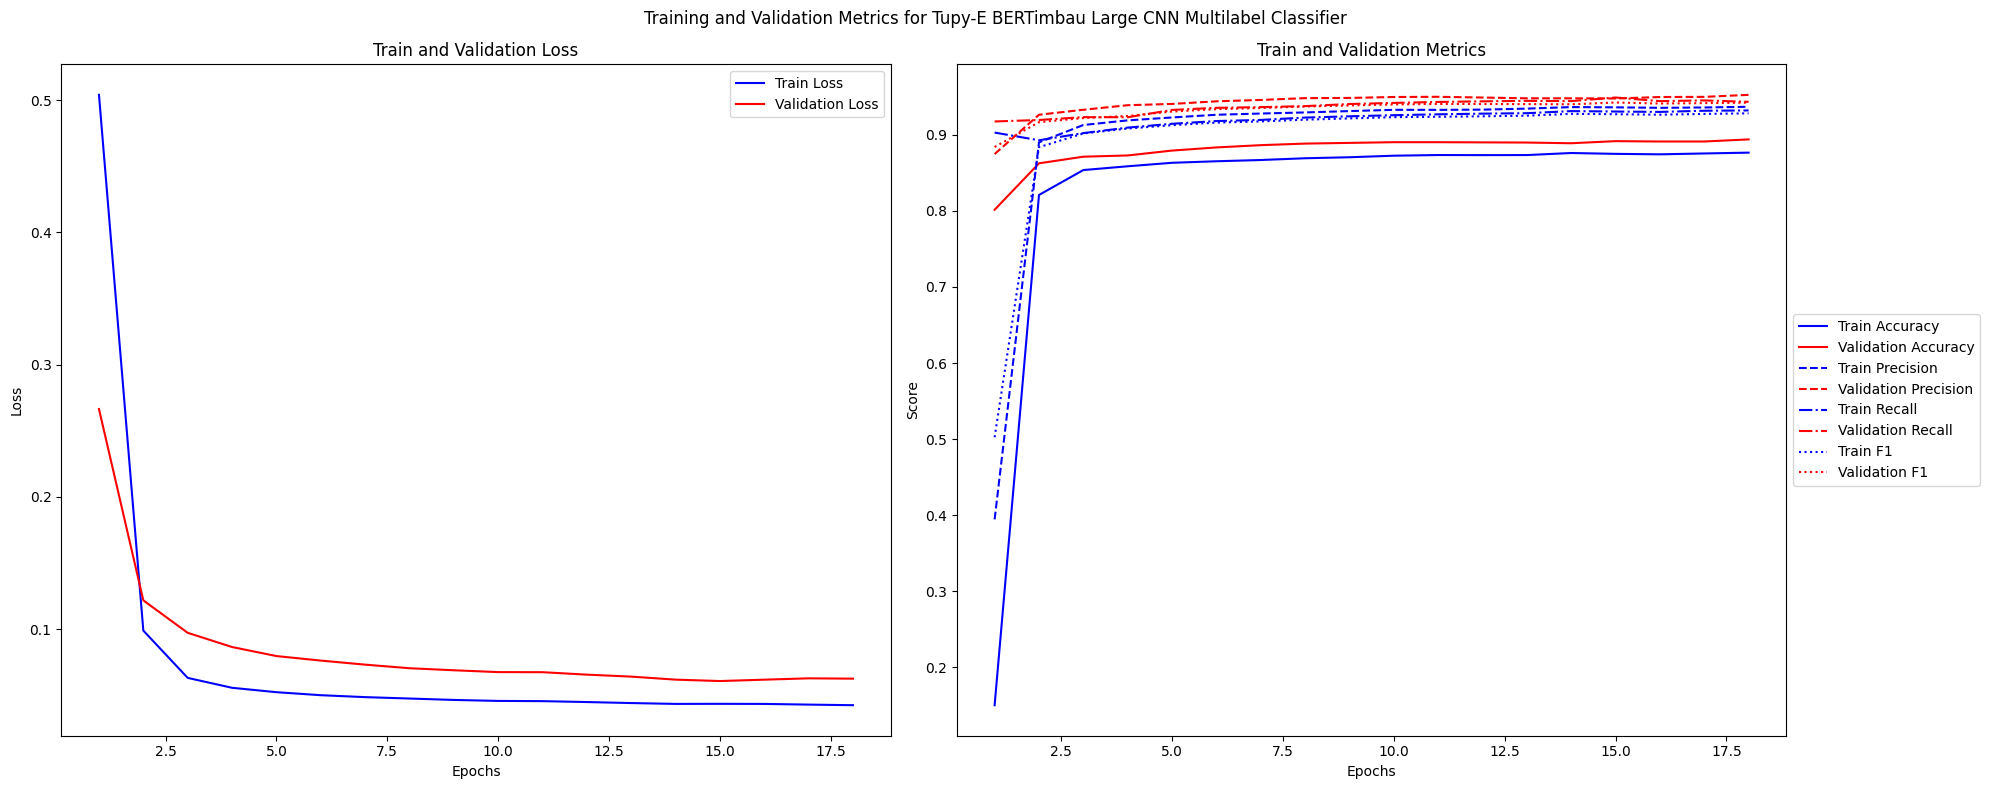

Test Epoch 1/50: 100%|██████████| 545/545 [01:00<00:00,  9.00batch/s, loss=0.0649]

                       precision    recall  f1-score  support
ageism                  0.000000  0.000000  0.000000      6.0
aporophobia             0.000000  0.000000  0.000000      9.0
body_shame              0.821429  0.821429  0.821429     28.0
capacitism              0.000000  0.000000  0.000000      4.0
lgbtphobia              0.871795  0.883117  0.877419     77.0
political               0.805825  0.709402  0.754545    117.0
racism                  0.750000  0.750000  0.750000     28.0
religious_intolerance   1.000000  0.500000  0.666667      8.0
misogyny                0.874214  0.785311  0.827381    177.0
xenophobia              0.961538  0.568182  0.714286     44.0
other                   0.835351  0.768374  0.800464    449.0
not_hate                0.964945  0.959633  0.962282   3815.0
micro avg               0.943017  0.917472  0.930069   4762.0
macro avg               0.657091  0.562121  0.597873   4762.0
weighted avg            0.938007  0.917472  0.926830   4762.0
samples 

In [14]:
# history = tupye_large_bertimbau_cnn_multilabel_trainer.history
# # Save the metrics to a CSV file
# metrics_tupye_large_bertimbau_cnn_multilabel_df = pd.DataFrame(history)
# metrics_tupye_large_bertimbau_cnn_multilabel_df.to_csv('./metrics/metrics_tupye_large_bertimbau_cnn_multilabel_5e6.csv', index=False)
tupye_large_bertimbau_cnn_multilabel_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau Large CNN Multilabel Classifier")
history = tupye_large_bertimbau_cnn_multilabel_trainer.evaluate(testing=True)

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

### Tupy-E BERTabaporu-CNN Multilabel Classification

In [ ]:
tupye_bert_abaporu_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_MULTILABEL_CLASSES), model_name=BERT_MODELS["bert_abaporu"], dropout_rate=0.5, freeze_bert_layers=0)

tupye_bert_abaporu_cnn_multilabel_trainer = Trainer(
    model=tupye_bert_abaporu_model,
    dataloader=tupye_cnn_multilabel_dataloader,
    class_names=TUPYE_MULTILABEL_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertabaporu",
    best_model_filename="best_multilabel_bertcnn_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=True
)

tupye_bert_abaporu_cnn_multilabel_trainer.fit()
tupye_bertabaporu_cnn_history = tupye_bert_abaporu_cnn_multilabel_trainer.evaluate(testing=True)
print(f'Test loss: {tupye_bertabaporu_cnn_history["loss"]} accuracy: {tupye_bertabaporu_cnn_history["accuracy"]} precision: {tupye_bertabaporu_cnn_history["precision"]} recall: {tupye_bertabaporu_cnn_history["recall"]} f1: {tupye_bertabaporu_cnn_history["f1"]}')

tupye_bert_abaporu_cnn_multilabel_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERT-Abaporu CNN Multilabel Classifier")
# tupye_bert_binary_trainer.plot_confusion_matrix(history['confusion_matrix'], class_names)

# Save the metrics to a CSV file
metrics_tupye_bertcnn_abaporu_multilabel_df = pd.DataFrame(tupye_bert_abaporu_cnn_multilabel_trainer.history)
metrics_tupye_bertcnn_abaporu_multilabel_df.to_csv('./metrics/metrics_tupye_bertcnn_abaporu_multilabel_5e6.csv', index=False)


# load the best model if it exists
best_model_path = os.path.join(tupye_bert_abaporu_cnn_multilabel_trainer.best_model_path, tupye_bert_abaporu_cnn_multilabel_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_bert_abaporu_cnn_multilabel_trainer.load_model(best_model_path)
    tupye_bert_abaporu_cnn_multilabel_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_bert_abaporu_cnn_multilabel_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_bert_abaporu_cnn_multilabel_trainer.fit()
    tupye_bert_abaporu_cnn_multilabel_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_bert_abaporu_cnn_multilabel_5e6.csv'))

history = tupye_bert_abaporu_cnn_multilabel_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_bert_abaporu_cnn_multilabel_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERT-Abaporu CNN Multilabel Classifier")

## Tupy-E BERTabaporu Multilabel Classification

In [ ]:
tupye_bert_abaporu_model = BertClassifier(num_classes=len(TUPYE_MULTILABEL_CLASSES), model_name=BERT_MODELS["bert_abaporu"])

tupye_bert_abaporu_multilabel_trainer = Trainer(
    model=tupye_bert_abaporu_model,
    dataloader=tupye_cnn_multilabel_dataloader,
    class_names=TUPYE_MULTILABEL_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertabaporu",
    best_model_filename="best_multilabel_bertcnn_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=True
)

# load the best model if it exists
best_model_path = os.path.join(tupye_bert_abaporu_multilabel_trainer.best_model_path, tupye_bert_abaporu_multilabel_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_bert_abaporu_multilabel_trainer.load_model(best_model_path)
    tupye_bert_abaporu_multilabel_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_bert_abaporu_multilabel_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_bert_abaporu_multilabel_trainer.fit()
    tupye_bert_abaporu_multilabel_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_bert_abaporu_multilabel_5e6.csv'))

history = tupye_bert_abaporu_multilabel_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_bert_abaporu_multilabel_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERT-Abaporu Multilabel Classifier")
